In [1]:
import numpy.random as npr

import jax
import jax.numpy as jnp 
import jax.random as jrnd
from jaxutils import Dataset

import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
# Imports from our code base
from active_search import get_next_y, get_next_candidate_baseline, get_next_candidate_qhull, compute_distances, get_next_candidate_noqhull
from plotting import plot_candidate, plot_eig
from gp_model import update_model
from search_no_gpjax import generate_true_function, sample_from_posterior

/home/dcai/miniconda3/envs/apm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Set up the problem

In [3]:
seed = 2 # seed to use for all expts
num_iters = 14 # number of iterations to run
knot_N = 40 # number of points to discretize space into

# grid to discretize design space into
knot_x = jnp.linspace(0, 1, knot_N)
design_space = knot_x[:, jnp.newaxis]

npr.seed(seed); rng_key = jrnd.PRNGKey(seed)

# generate true data and envelope
true_y, true_envelope = generate_true_function(design_space, knot_N)

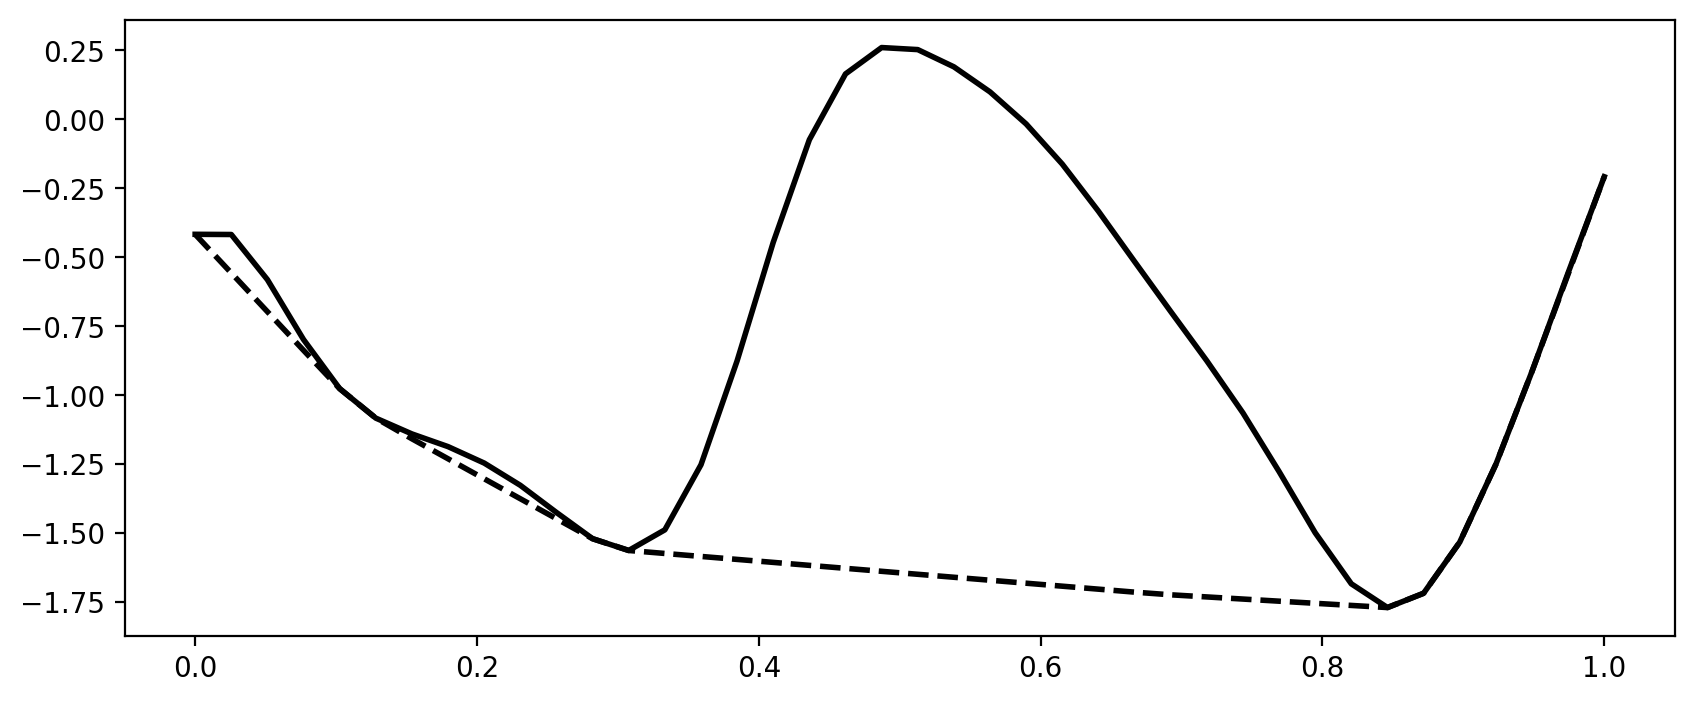

In [4]:
plt.figure(figsize=(10,4))
plt.plot(design_space, true_y, c="k", lw=2)
plt.plot(design_space, true_envelope.T, c="k", ls="--", lw=2)

In [39]:
# if we wanted to get hyperparameters w.r.t. all data first and pass this in
_, _, _, init_params = update_model(Dataset(X=design_space, y=true_y[:,jnp.newaxis]), design_space, rng_key, update_params=True)
init_params

# NOTE: for the rest of this notebook, we'll just set it to the true values.

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1649.65it/s, Objective=43.52]


{'kernel': {'lengthscale': Array([1.32740389], dtype=float64),
  'variance': Array([0.72862933], dtype=float64)},
 'likelihood': {'obs_noise': Array([0.72193114], dtype=float64)},
 'mean_function': {}}

# Baseline: no convex hull information

Iteration:  0
CPU times: user 1.7 s, sys: 77.6 ms, total: 1.77 s
Wall time: 2.2 s


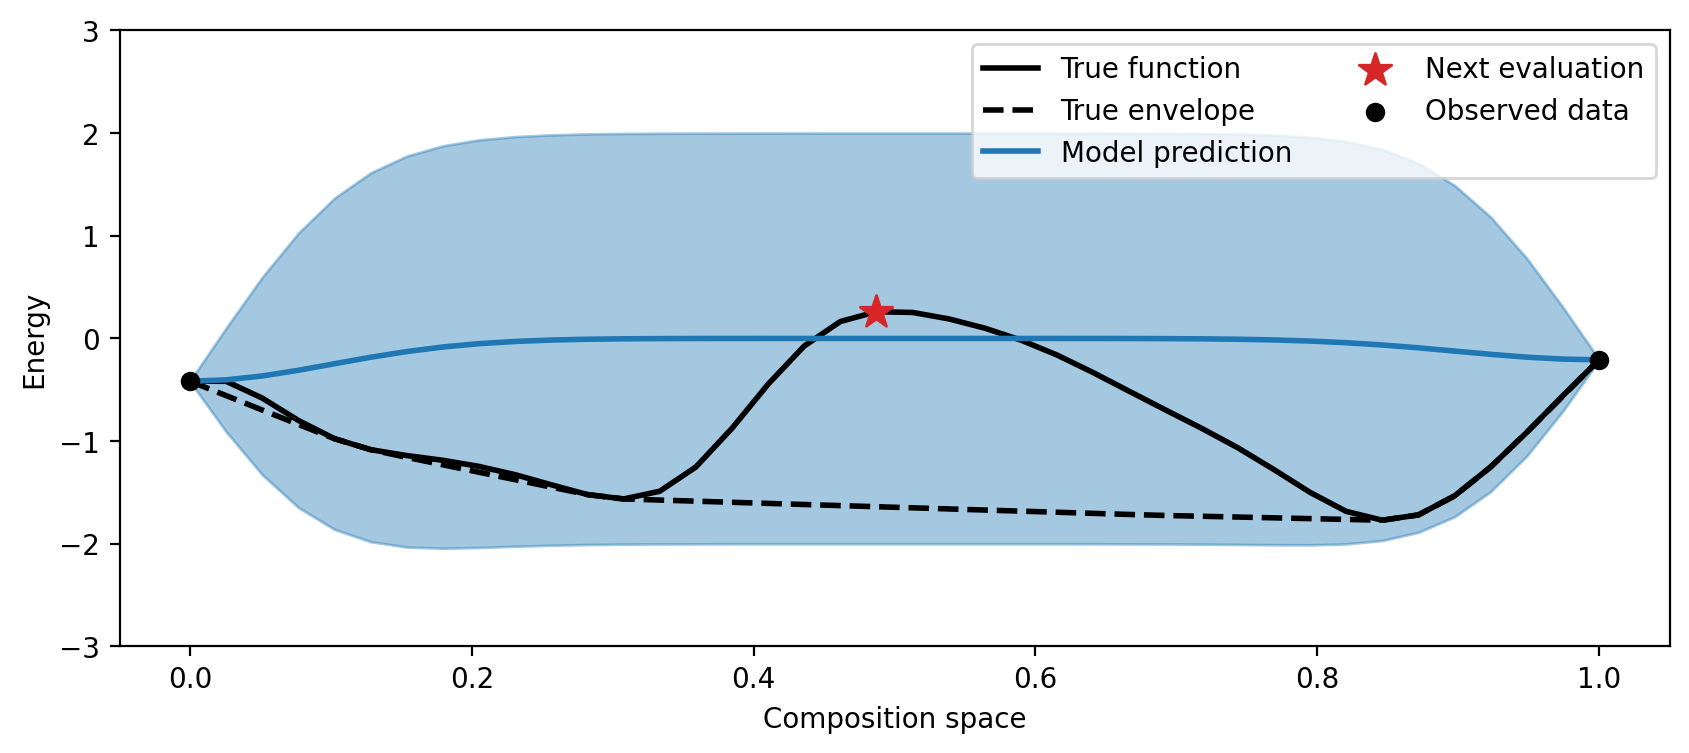

Iteration:  1
CPU times: user 1.24 s, sys: 37.1 ms, total: 1.28 s
Wall time: 1.47 s


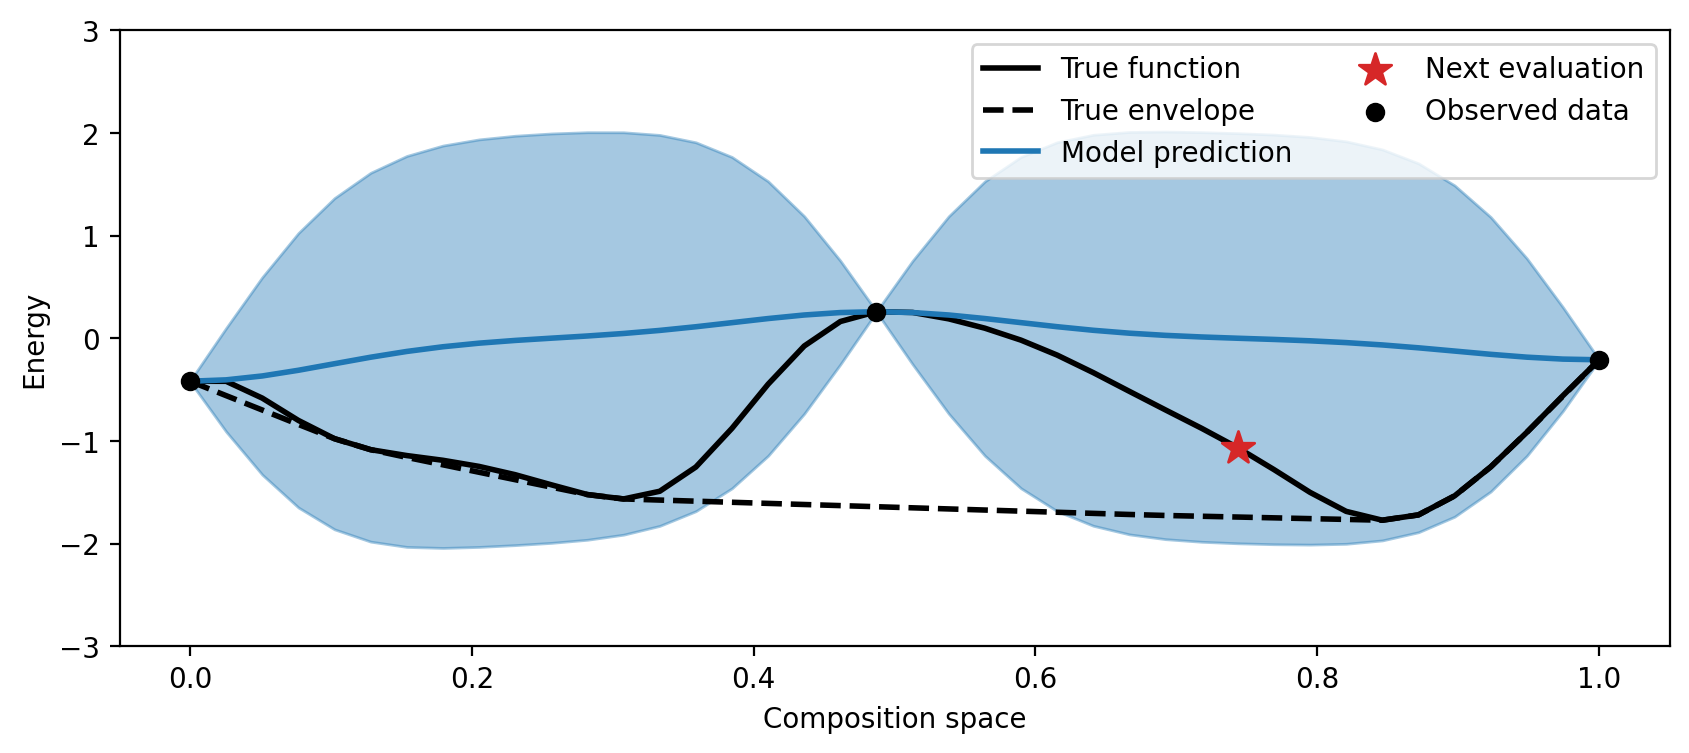

Iteration:  2
CPU times: user 1.26 s, sys: 42.9 ms, total: 1.31 s
Wall time: 1.43 s


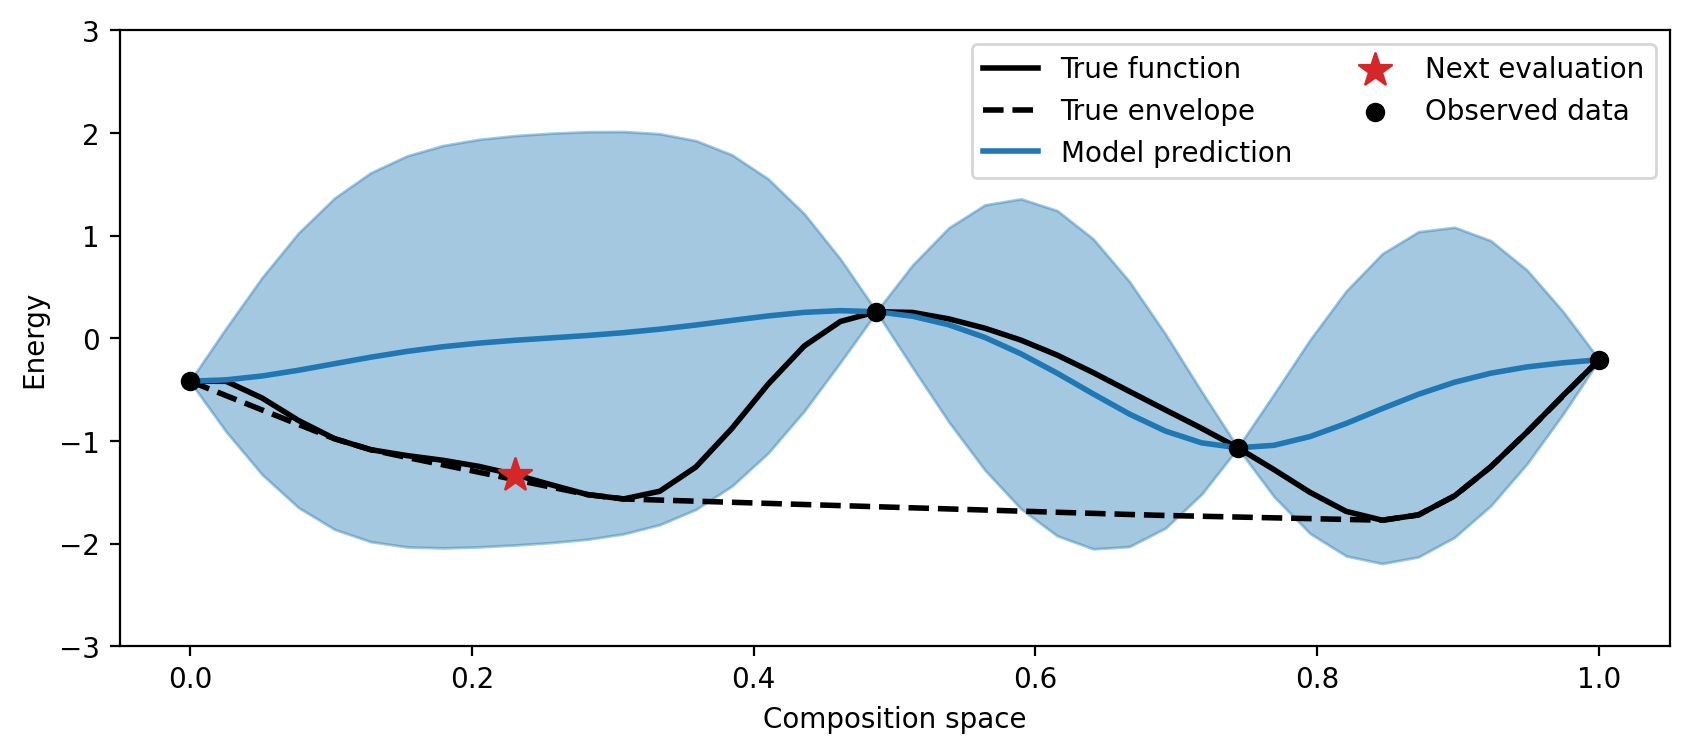

Iteration:  3
CPU times: user 1.15 s, sys: 71 ms, total: 1.23 s
Wall time: 1.4 s


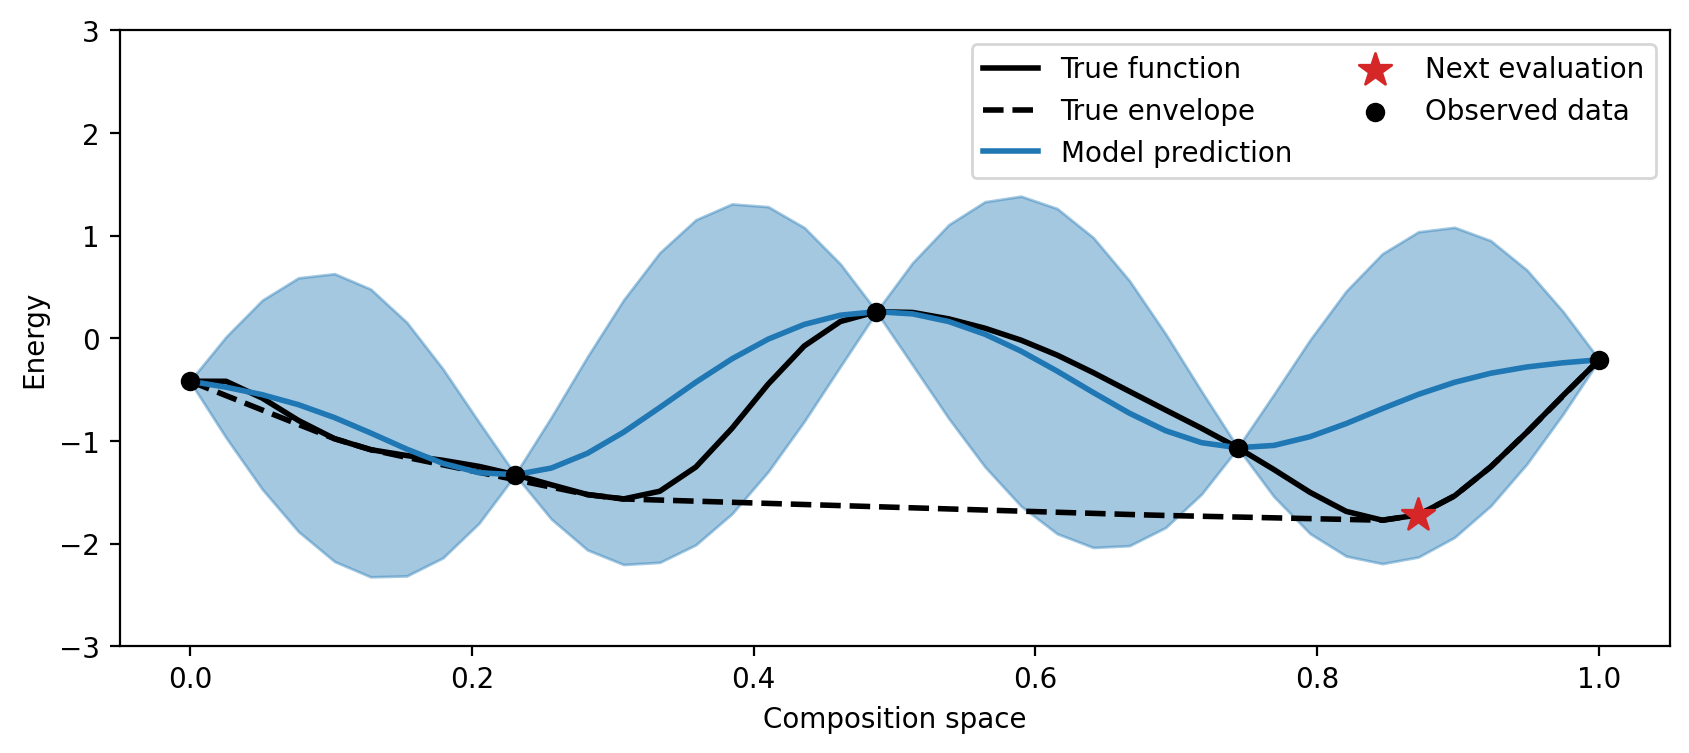

Iteration:  4
CPU times: user 1.15 s, sys: 56.7 ms, total: 1.21 s
Wall time: 1.39 s


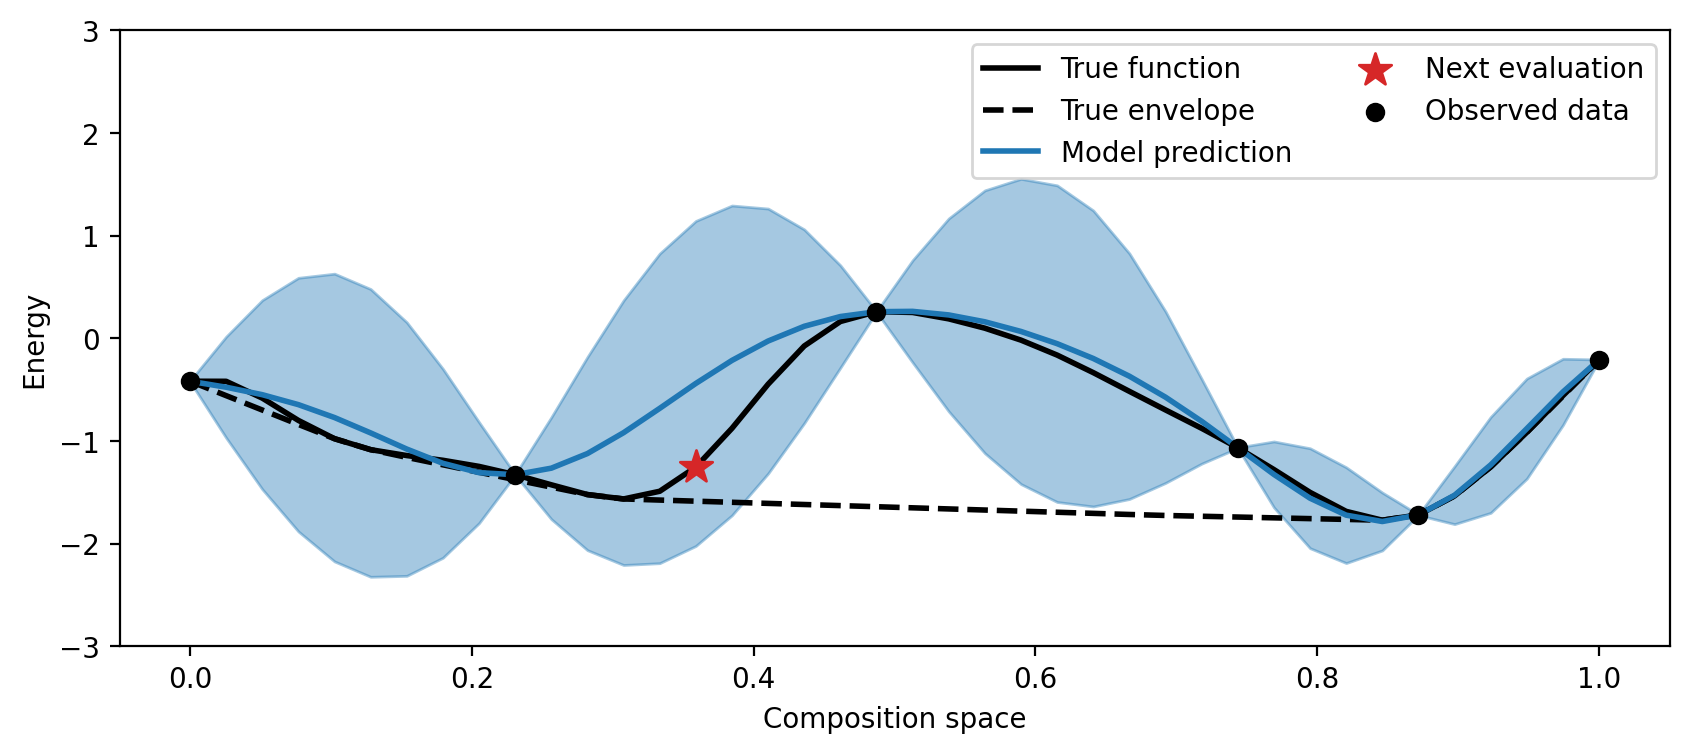

Iteration:  5
CPU times: user 1.13 s, sys: 33.3 ms, total: 1.17 s
Wall time: 1.34 s


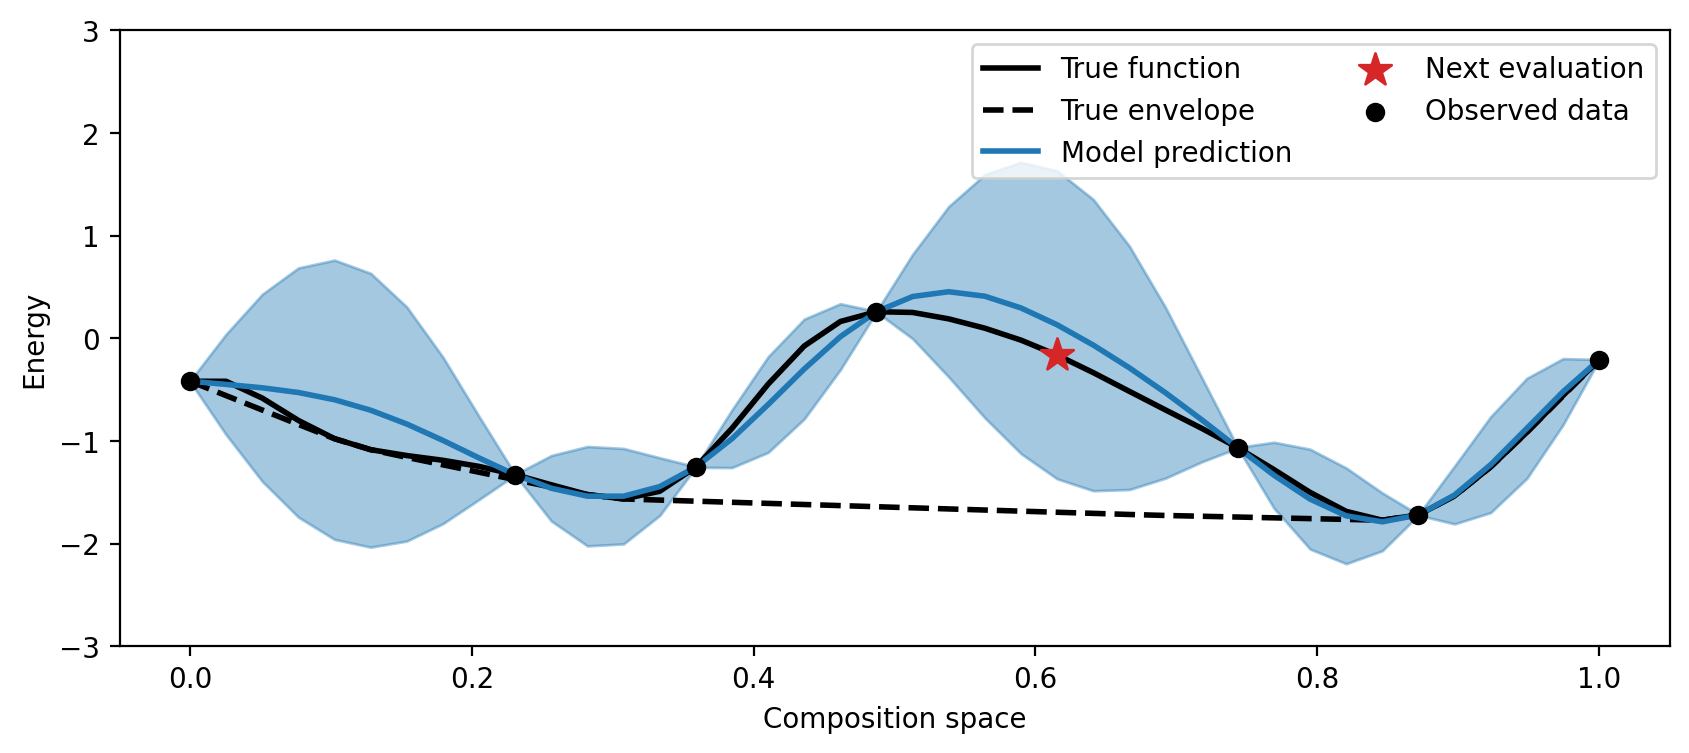

Iteration:  6
CPU times: user 1.09 s, sys: 49 ms, total: 1.14 s
Wall time: 1.31 s


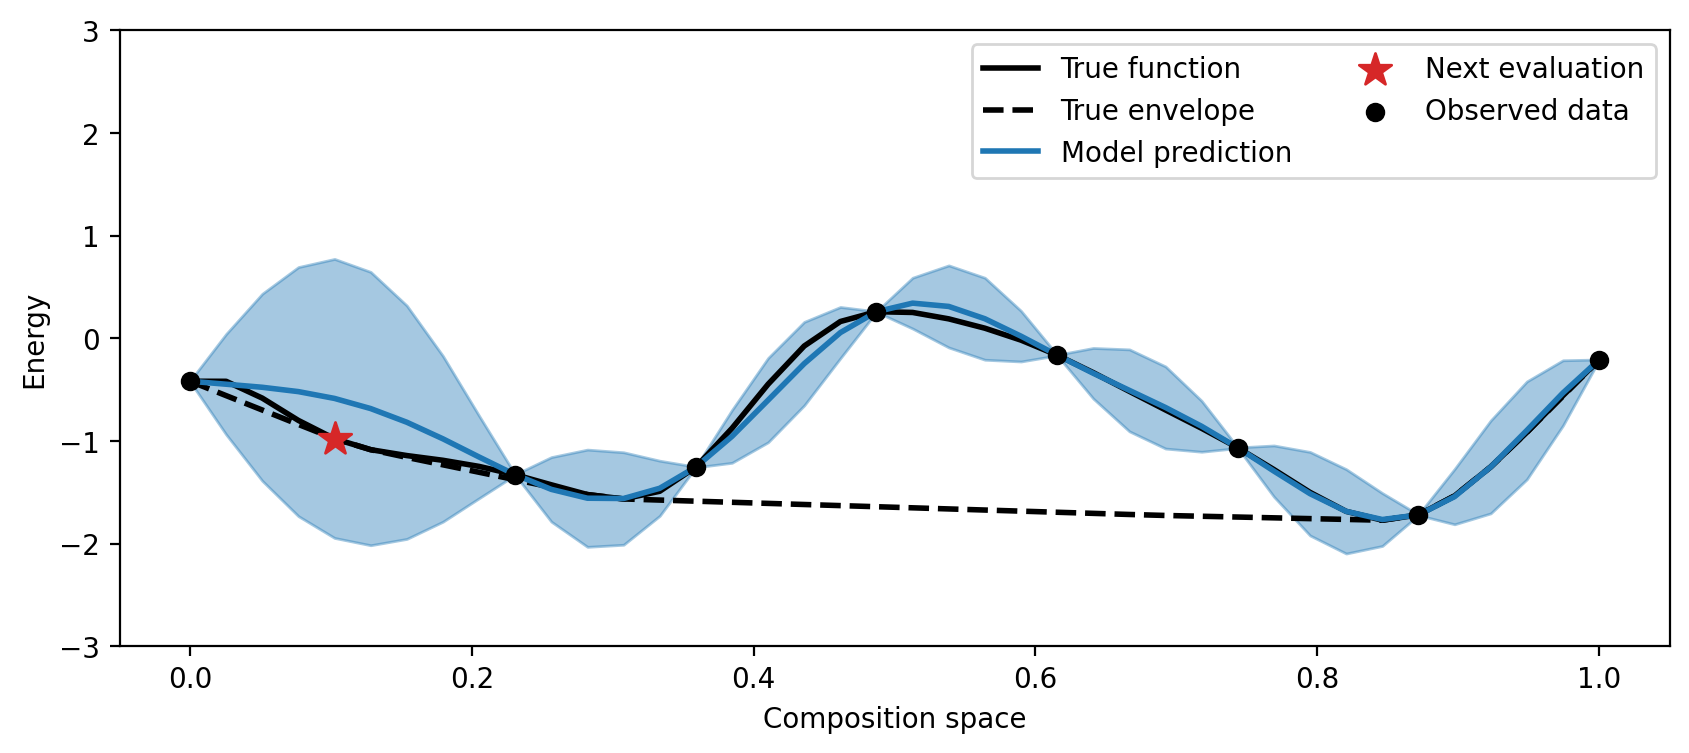

Iteration:  7
CPU times: user 1.11 s, sys: 37.1 ms, total: 1.15 s
Wall time: 1.3 s


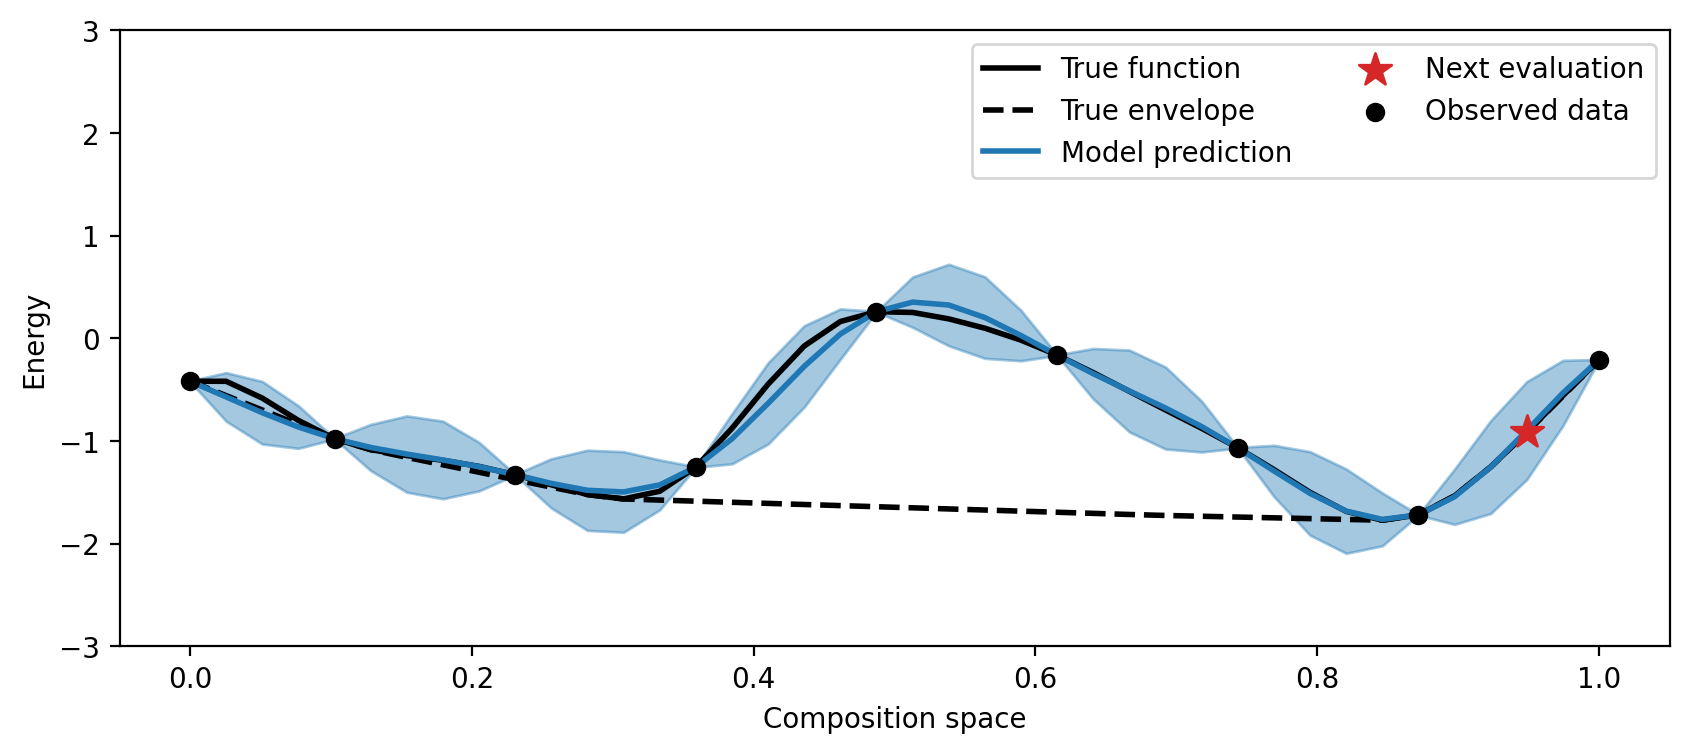

Iteration:  8
CPU times: user 1.07 s, sys: 47 ms, total: 1.12 s
Wall time: 1.32 s


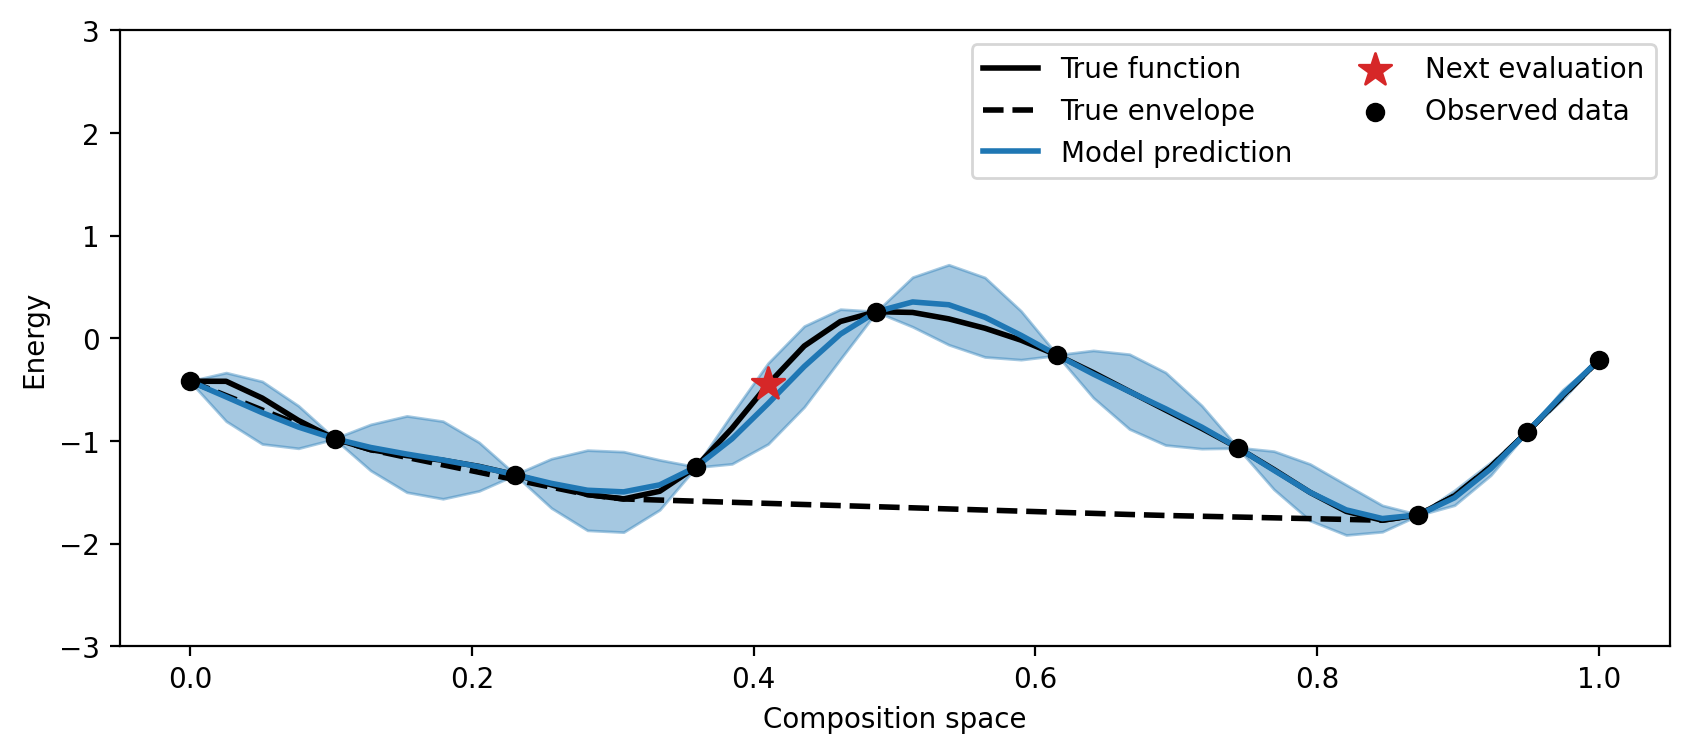

Iteration:  9
CPU times: user 1.04 s, sys: 52.1 ms, total: 1.09 s
Wall time: 1.28 s


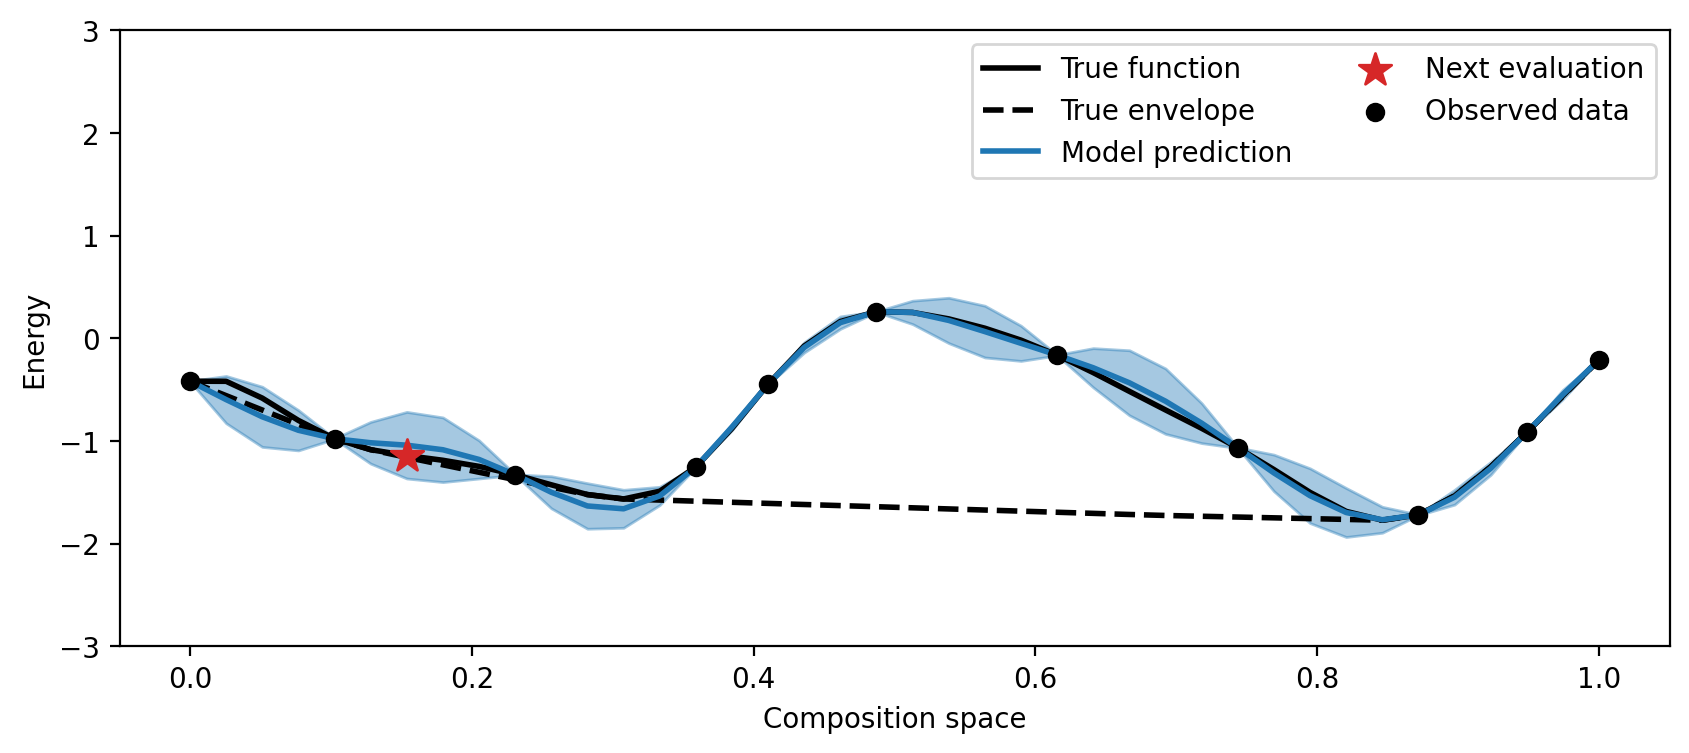

Iteration:  10
CPU times: user 1.03 s, sys: 33.9 ms, total: 1.07 s
Wall time: 1.24 s


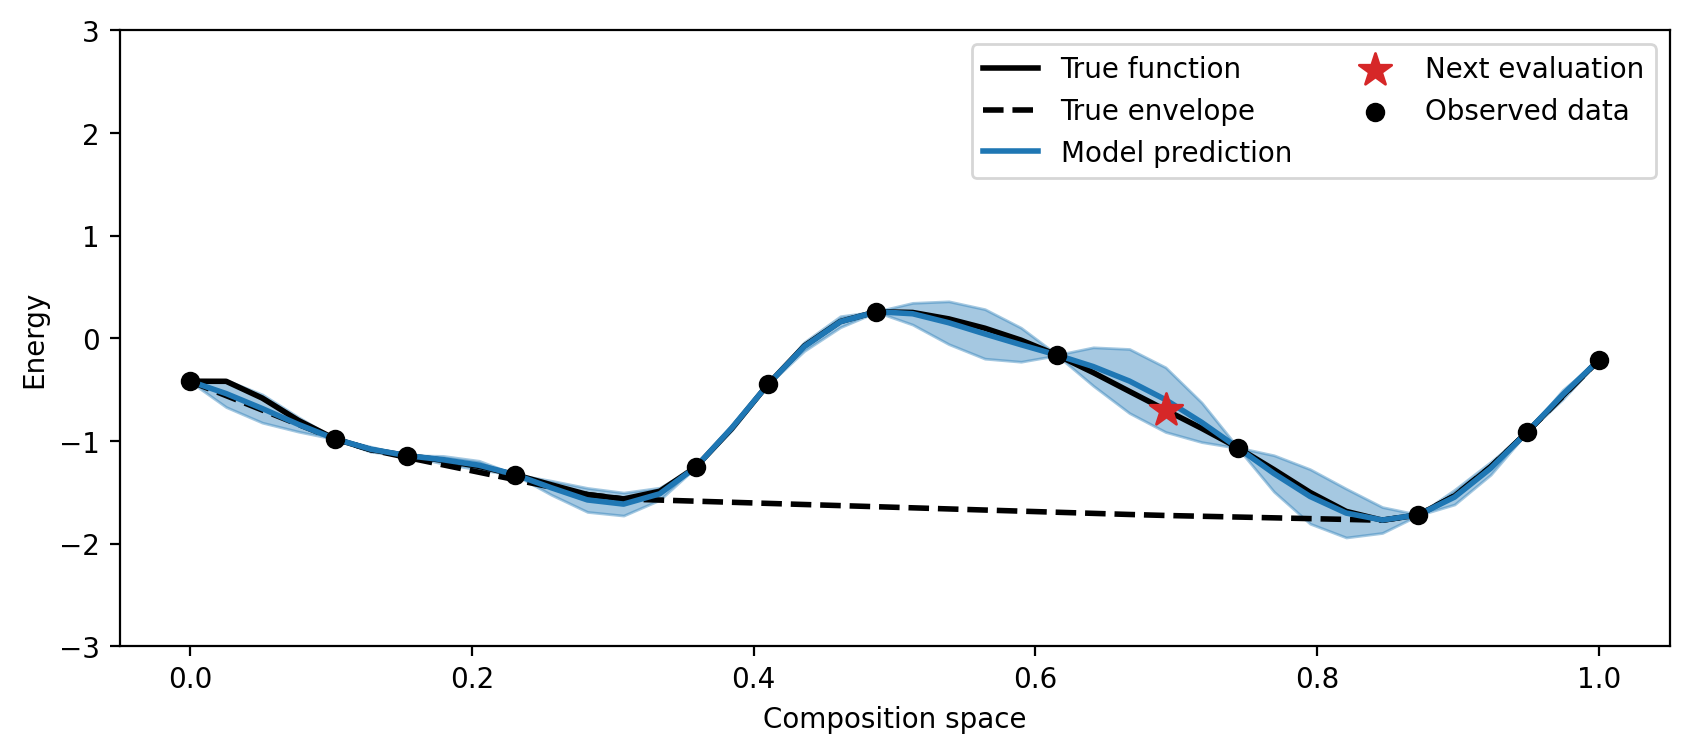

Iteration:  11
CPU times: user 975 ms, sys: 57.3 ms, total: 1.03 s
Wall time: 1.21 s


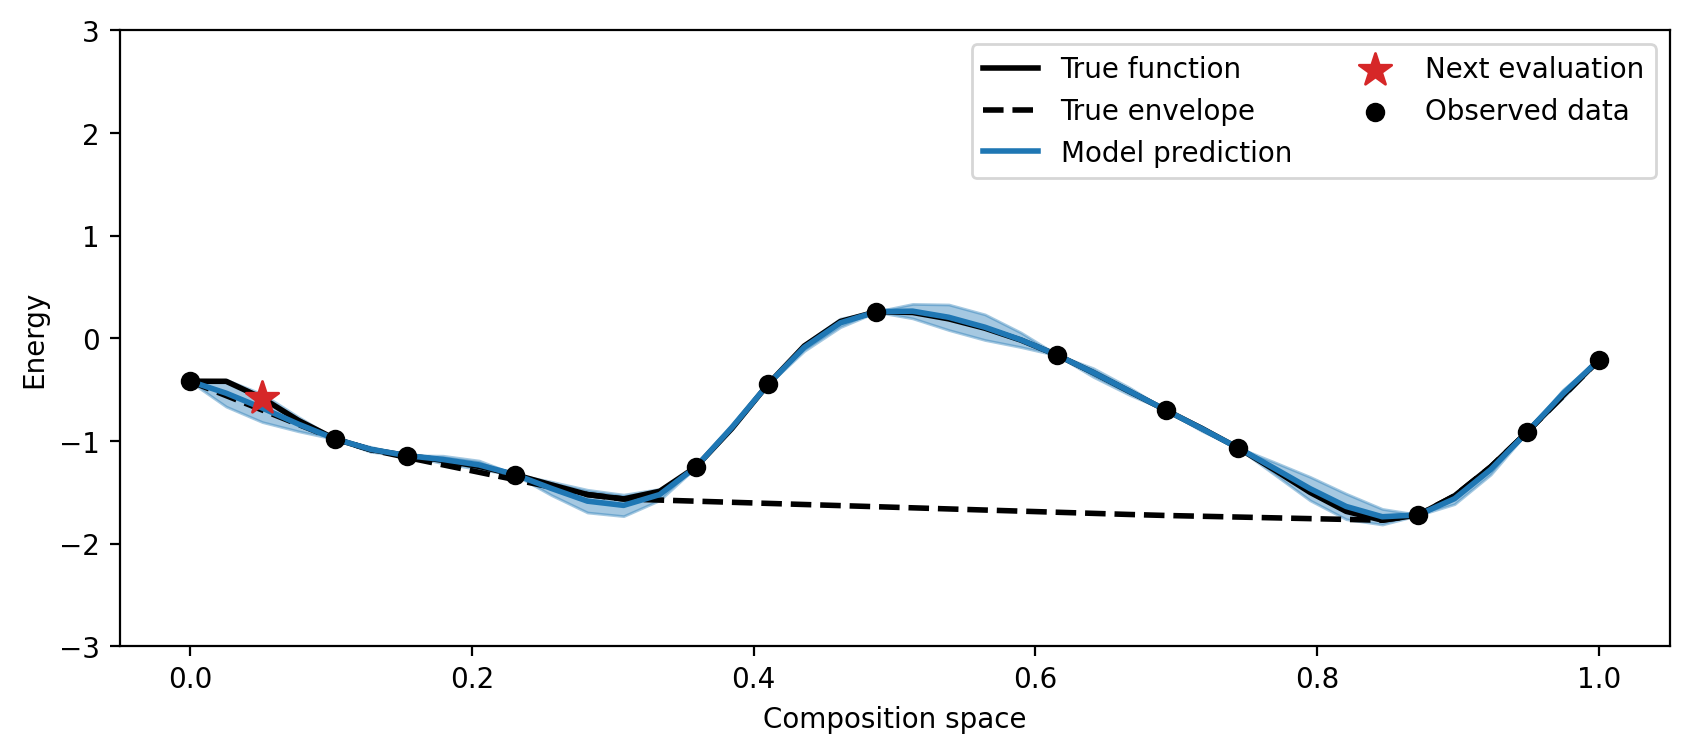

Iteration:  12
CPU times: user 961 ms, sys: 43.2 ms, total: 1 s
Wall time: 1.19 s


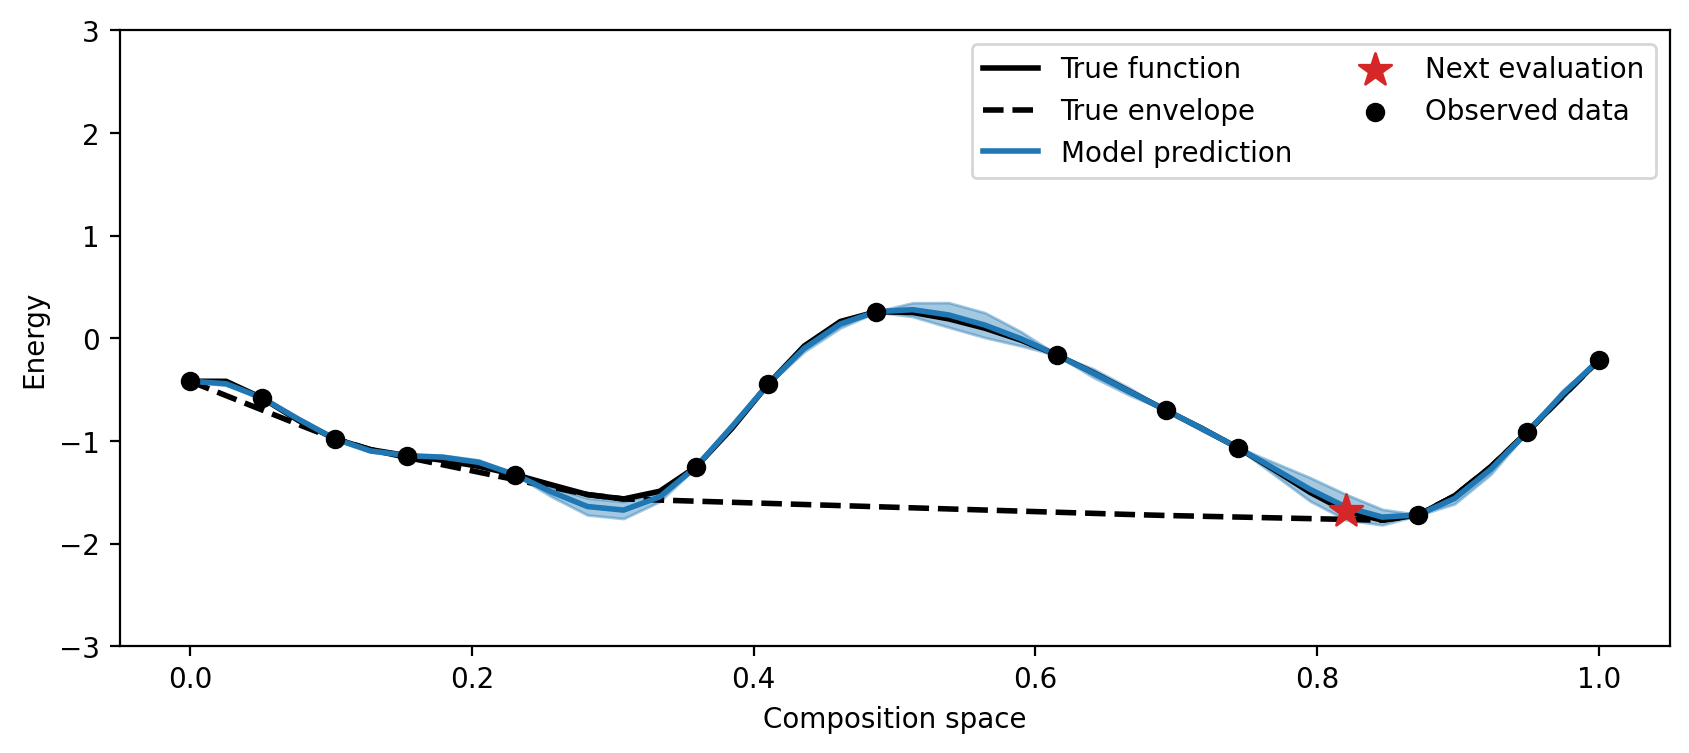

Iteration:  13
CPU times: user 963 ms, sys: 28.8 ms, total: 992 ms
Wall time: 1.16 s


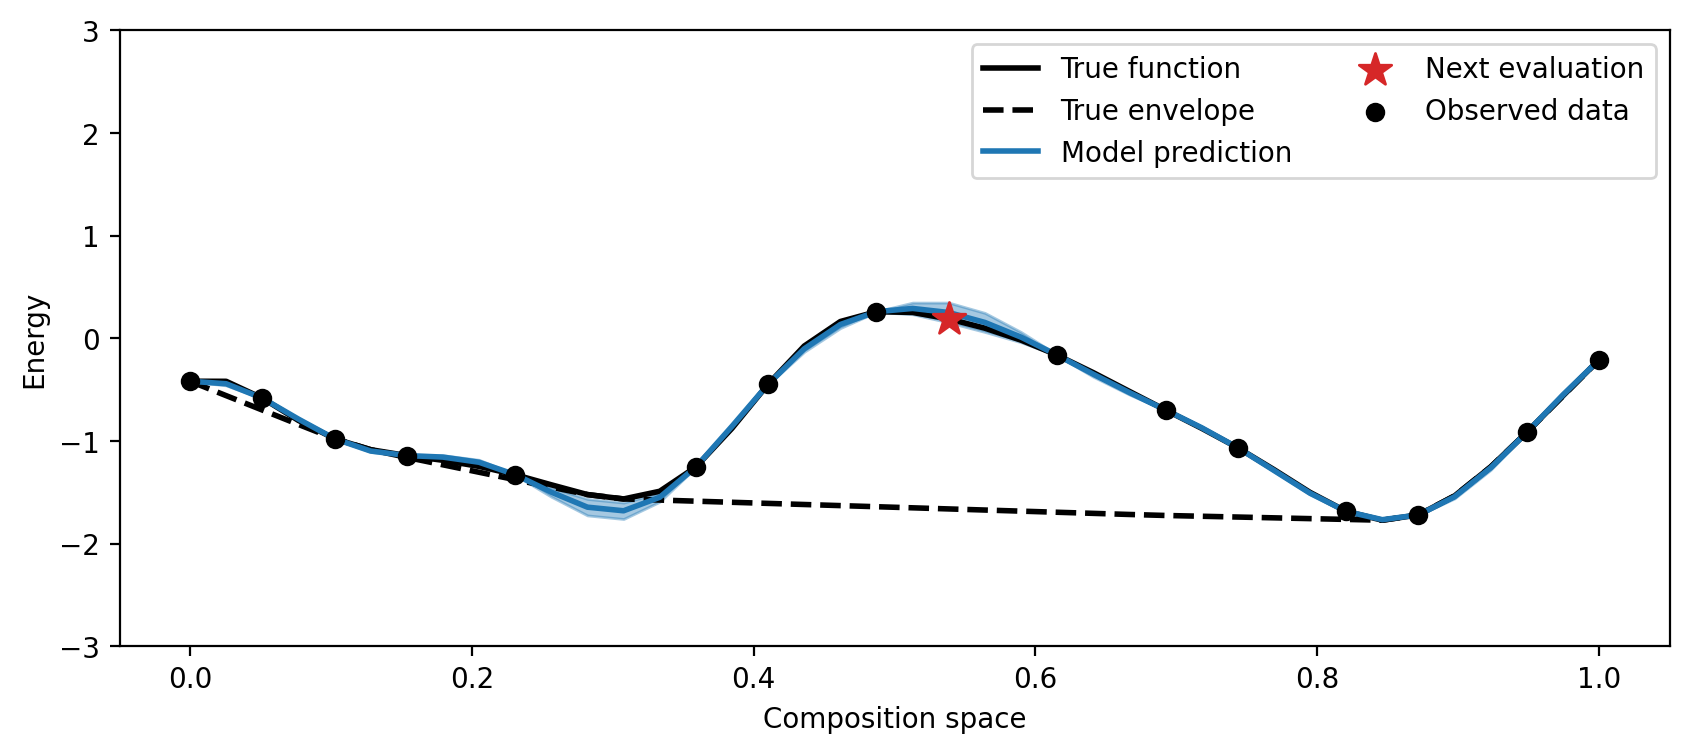

In [5]:
npr.seed(seed); rng_key = jrnd.PRNGKey(seed)

# Suppose we start out by observing the two end points
train_x = jnp.array([design_space[0], design_space[-1]]); train_y = jnp.array([true_y[0], true_y[-1]])
dataset = Dataset(X=train_x, y=train_y[:,jnp.newaxis])
designs = design_space[1:-1]

distances_baseline = []; distances_baseline.append(compute_distances(dataset, design_space, true_envelope))

# Update the model given the data above
pred_mean, pred_cov, posterior, params = update_model(dataset, design_space, rng_key, update_params=False)

for i in range(num_iters):
    print("Iteration: ", i)

    %time next_x, entropy_change = get_next_candidate_baseline(posterior, params, dataset, designs, design_space)
    #print(entropy_change)
    plot_candidate(knot_x, true_y, true_envelope, pred_mean, pred_cov, [], dataset, next_x, entropy_change, plot_eig=False, plot_hulls=False)
    
    # add observations to data and update model
    dataset = dataset + Dataset(X=jnp.atleast_2d(next_x), y=jnp.atleast_2d(get_next_y(true_y, design_space, next_x)))
    designs = jnp.delete(designs, (designs == next_x).argmax())[:, jnp.newaxis]
    pred_mean, pred_cov, posterior, params = update_model(dataset, design_space, rng_key, update_params=False)
    distances_baseline.append(compute_distances(dataset, design_space, true_envelope))

# Convex-hull-aware active search (CHAASe)

## No Qhull version

Iteration:  0
CPU times: user 27.2 s, sys: 20.3 ms, total: 27.3 s
Wall time: 25.9 s
[0.07692308] [0.76336899 0.81550241 0.83410708 0.81694012 0.77854444 0.72550949
 0.67320948 0.62636827 0.58868961 0.55865106 0.52963769 0.50123828
 0.47503819 0.45805877 0.45240911 0.45609524 0.46093632 0.46276753
 0.46794324 0.47645583 0.48522956 0.4911743  0.49354122 0.49373314
 0.49382147 0.49933404 0.5133172  0.53686744 0.56612313 0.60101625
 0.6440861  0.69129188 0.73596174 0.76867793 0.77926085 0.77111778
 0.73984865 0.69156399]


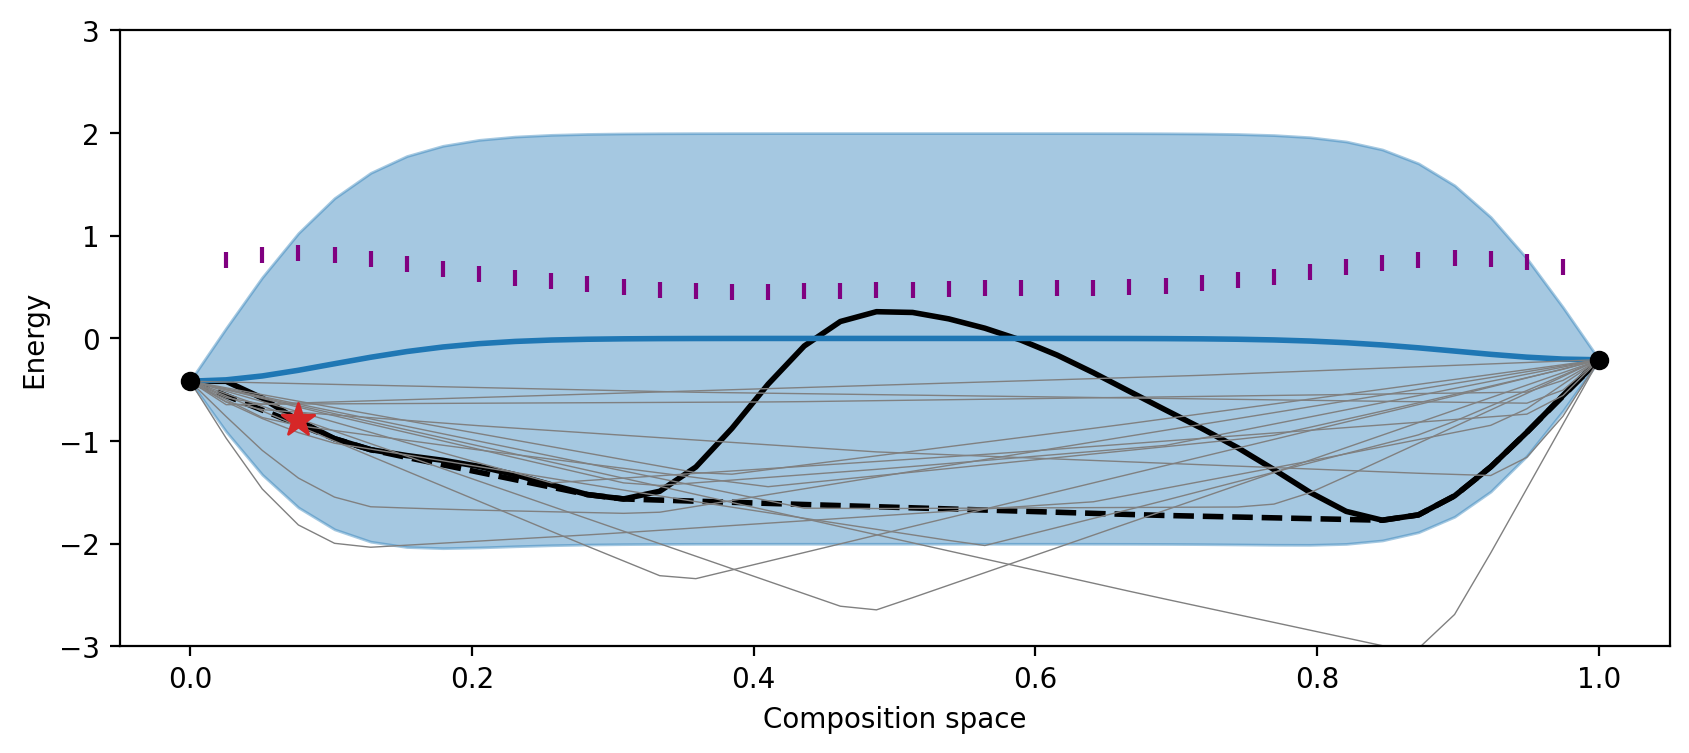

Iteration:  1
CPU times: user 37.7 s, sys: 0 ns, total: 37.7 s
Wall time: 36.4 s
[0.05128205] [2.29366093 2.35467654 2.34469023 2.34033238 2.27759751 2.156677
 2.03139152 1.90949632 1.81409739 1.74160418 1.68457528 1.64351749
 1.6115031  1.58336397 1.57476263 1.58192007 1.58887167 1.60768776
 1.6253631  1.62650776 1.63057701 1.64421535 1.63273416 1.61087674
 1.61076407 1.62010127 1.64516282 1.6759015  1.71693208 1.75665763
 1.79555335 1.83840974 1.86932826 1.87800394 1.85150428 1.78774635
 1.71388507]


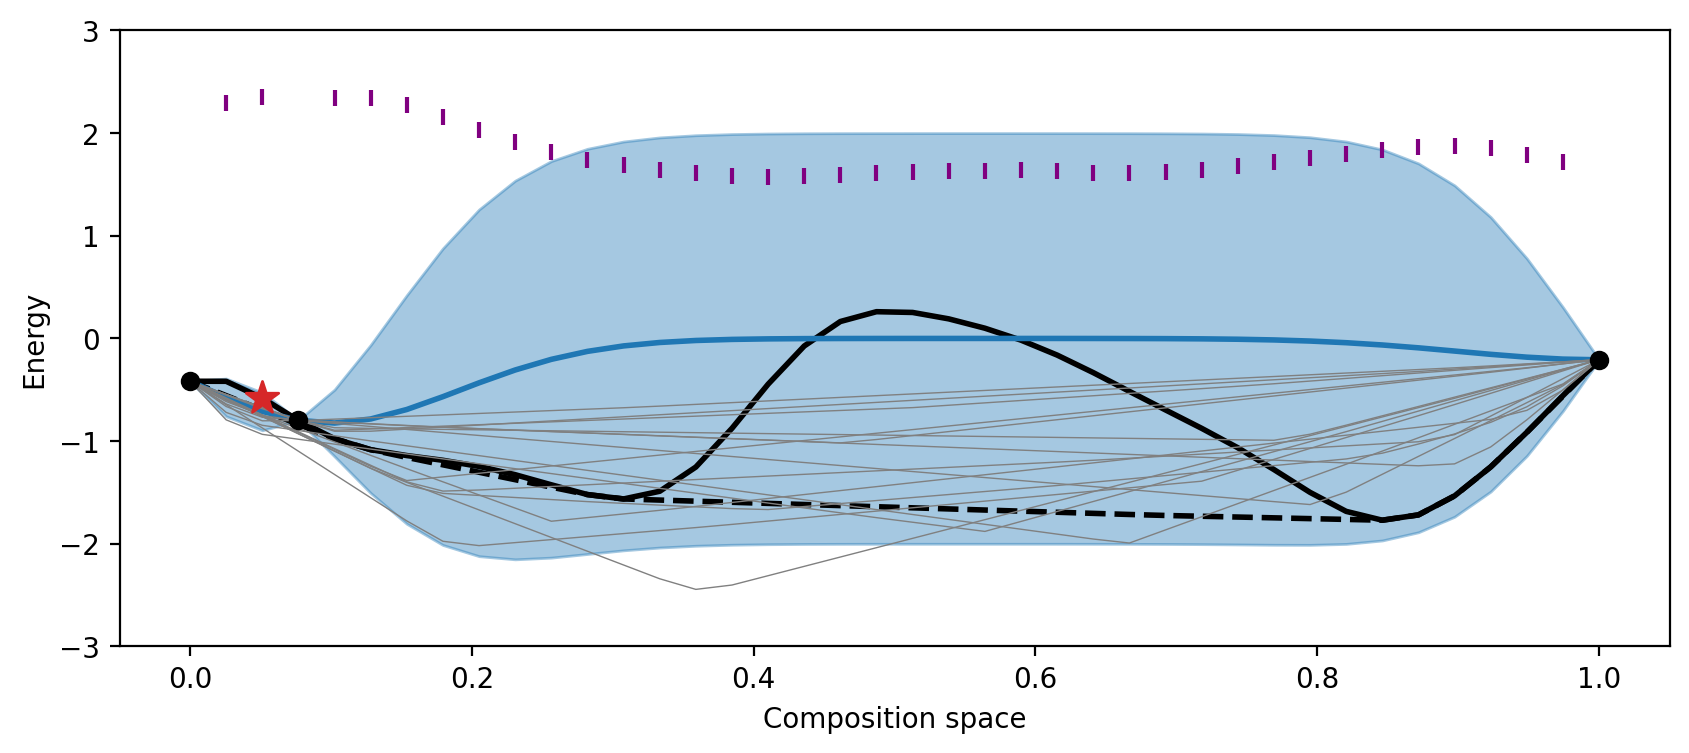

Iteration:  2
CPU times: user 34.5 s, sys: 20.5 ms, total: 34.5 s
Wall time: 33.2 s
[0.17948718] [1.48113862 2.02567085 2.53940559 2.59224938 2.6067648  2.3719942
 2.11153549 1.84828416 1.63261989 1.48144923 1.38321655 1.33690537
 1.30901122 1.28941356 1.30012845 1.30369419 1.32630788 1.34873539
 1.36346062 1.37676209 1.37595215 1.3766294  1.3619752  1.35341334
 1.35107454 1.3512804  1.34886702 1.36693001 1.3933516  1.43002775
 1.48878965 1.54096766 1.57241201 1.58288219 1.55929323 1.51215546]


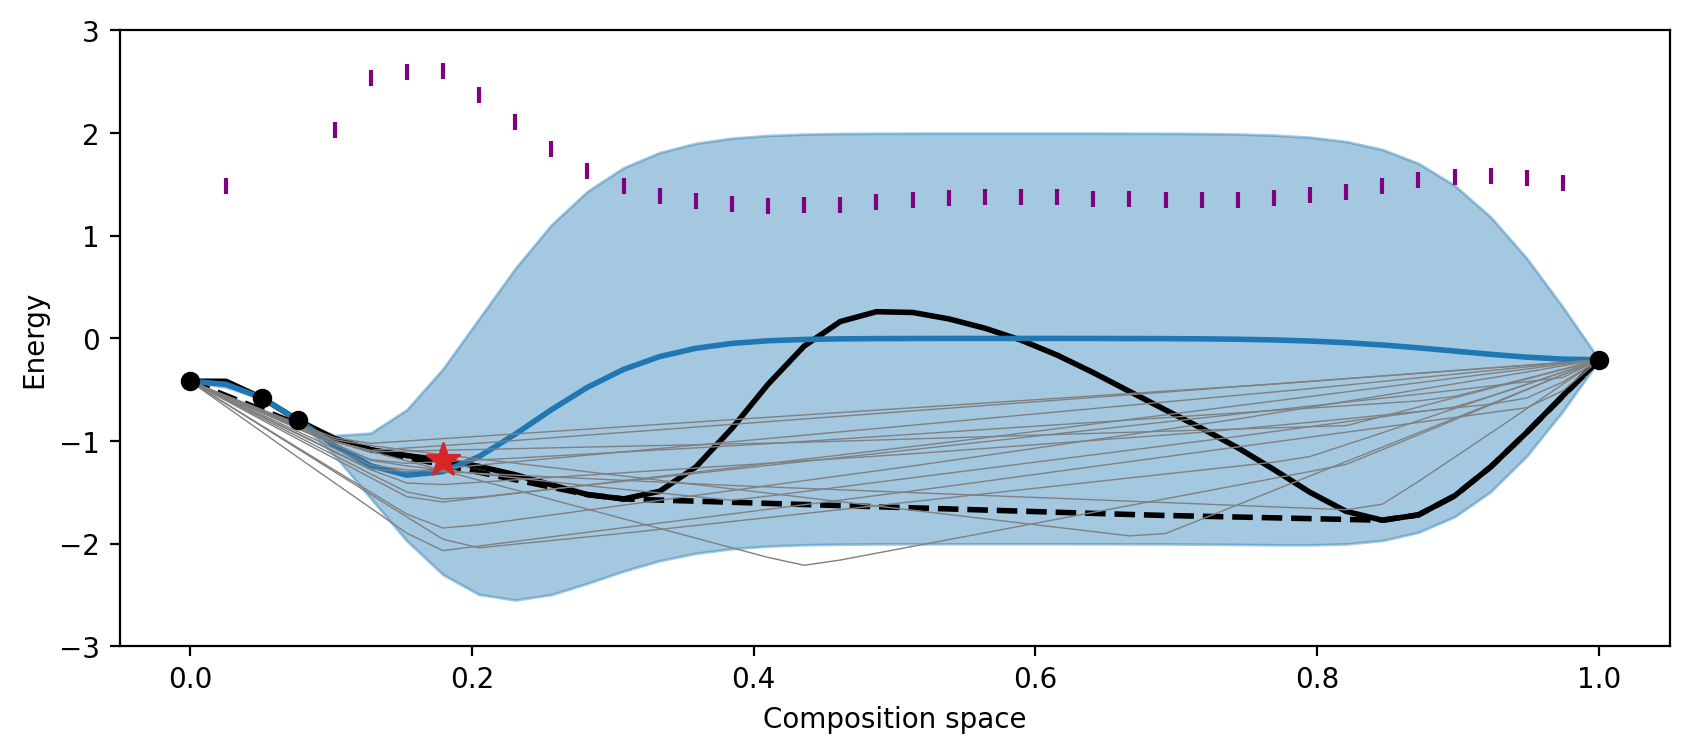

Iteration:  3
CPU times: user 38.4 s, sys: 19.6 ms, total: 38.4 s
Wall time: 37.1 s
[0.8974359] [0.7753621  0.932311   1.03015339 1.02974421 0.97755684 0.96895007
 0.93883341 0.90142368 0.86707841 0.85951181 0.85310281 0.87272244
 0.89023035 0.90331495 0.94125982 0.97314018 0.97483201 0.96006916
 0.9501649  0.96277519 0.98060343 0.99918775 1.01974353 1.03803162
 1.04676728 1.06719067 1.10512053 1.15005871 1.20286195 1.2485369
 1.28520536 1.31053807 1.30381554 1.25008796 1.18205036]


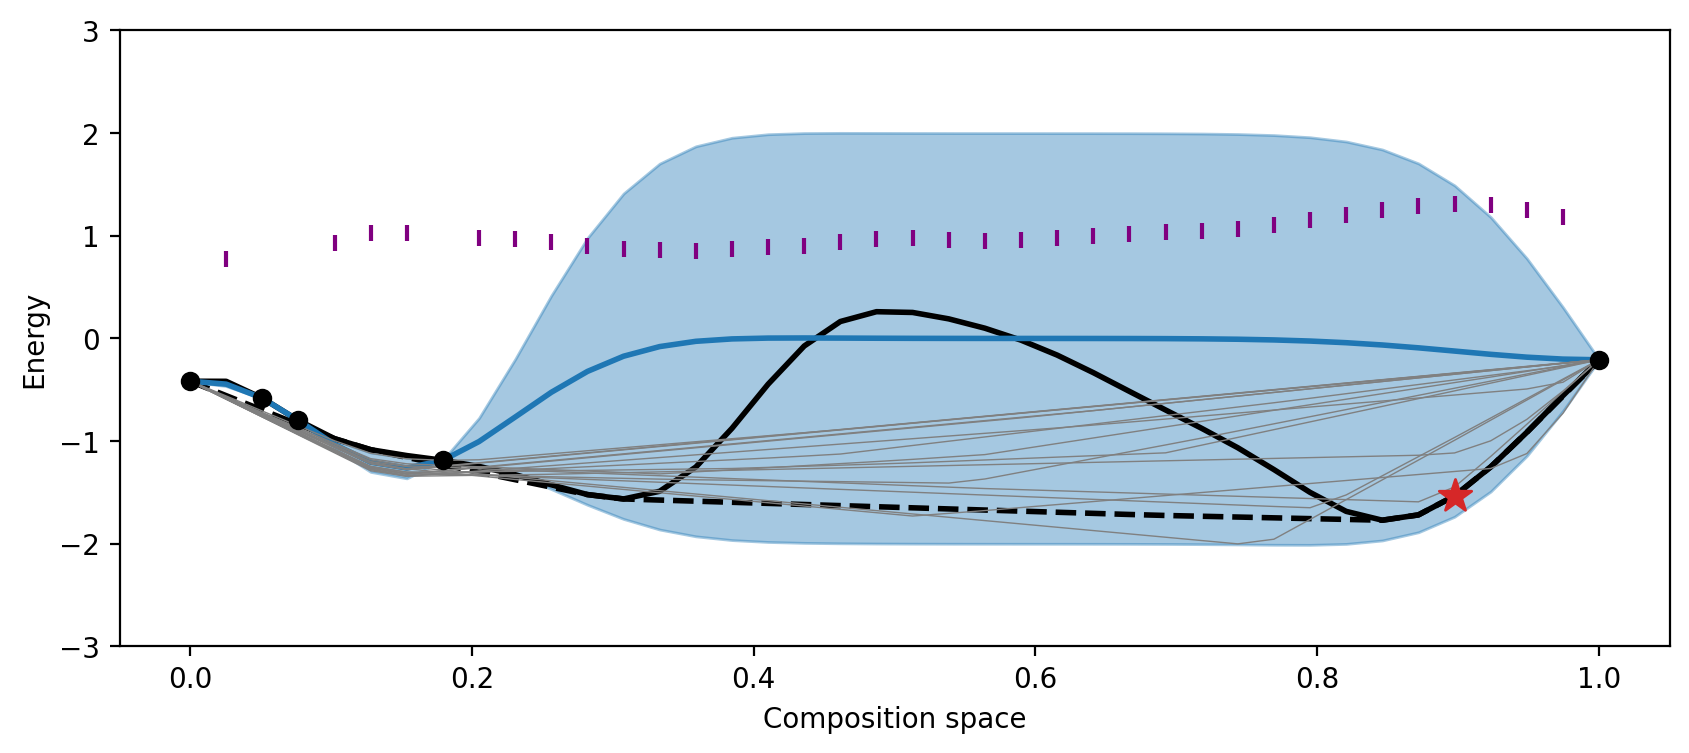

Iteration:  4
CPU times: user 40.4 s, sys: 20.3 ms, total: 40.4 s
Wall time: 39.2 s
[0.92307692] [2.42079296 2.52245007 2.62007898 2.59994834 2.56763148 2.61456093
 2.63034325 2.62853644 2.6202192  2.61153568 2.61530574 2.61283544
 2.6043309  2.61420389 2.63349777 2.65864111 2.67544513 2.68574326
 2.66482689 2.63462813 2.59259873 2.55635429 2.55744099 2.61695829
 2.73376081 2.89338039 3.11129279 3.37690301 3.65498115 3.90526102
 4.05196183 4.66290126 4.61789033 4.35031888]


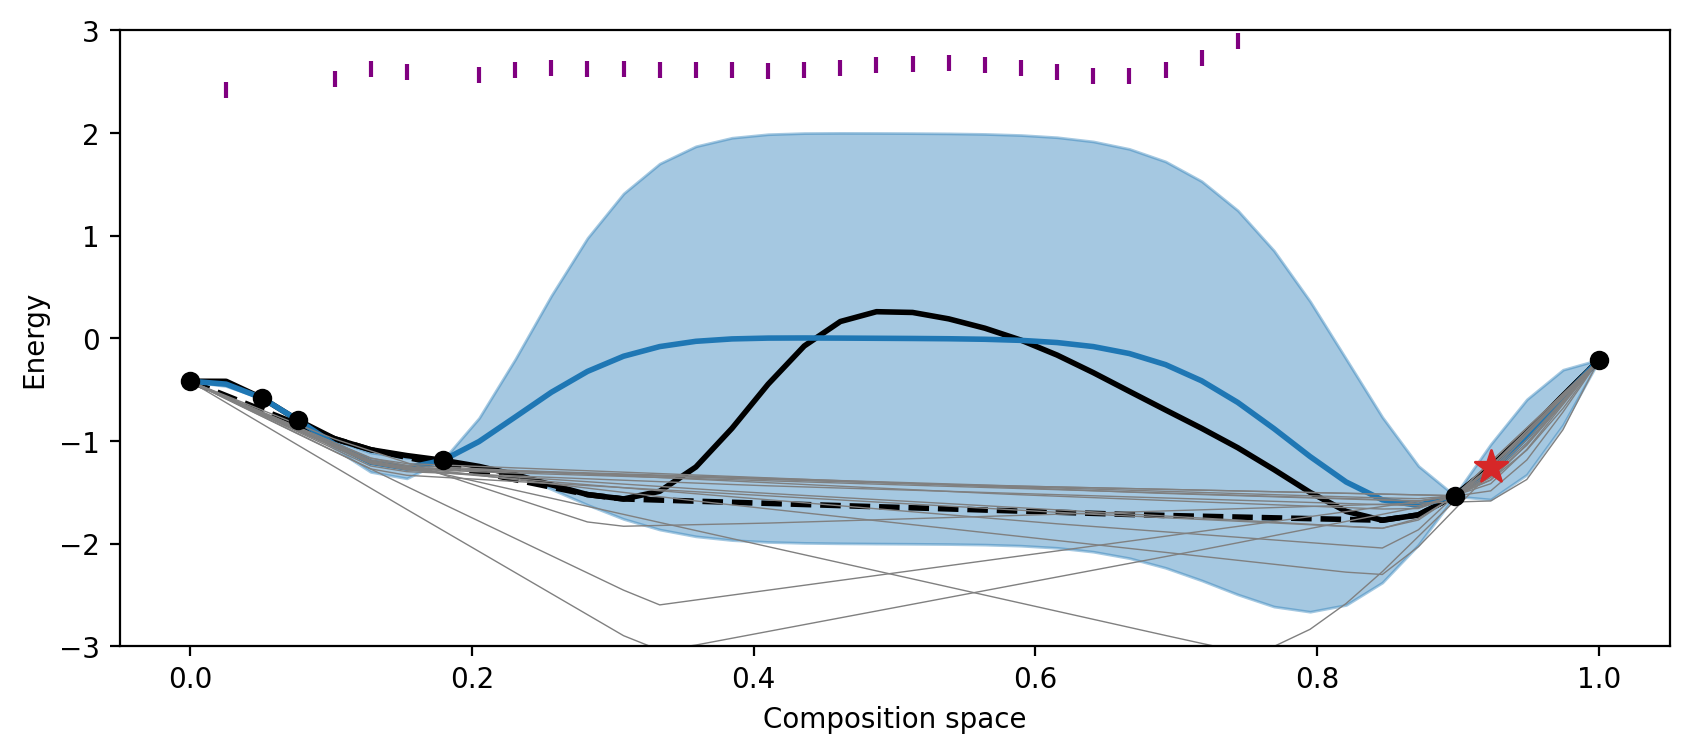

Iteration:  5
CPU times: user 40.9 s, sys: 8.25 ms, total: 40.9 s
Wall time: 39.6 s
[0.84615385] [1.84216634 1.92693248 2.05588142 2.05597982 2.03209497 2.08001936
 2.09668926 2.0897874  2.07165535 2.05199041 2.02978509 2.00186321
 1.97888628 1.97878601 2.0048358  2.03866198 2.07113952 2.07296916
 2.07396885 2.07454575 2.07241579 2.07990189 2.13015267 2.22752817
 2.37240709 2.56011298 2.78978811 3.04789645 3.30770653 3.42068425
 2.93357902 2.72304084 2.9503974 ]


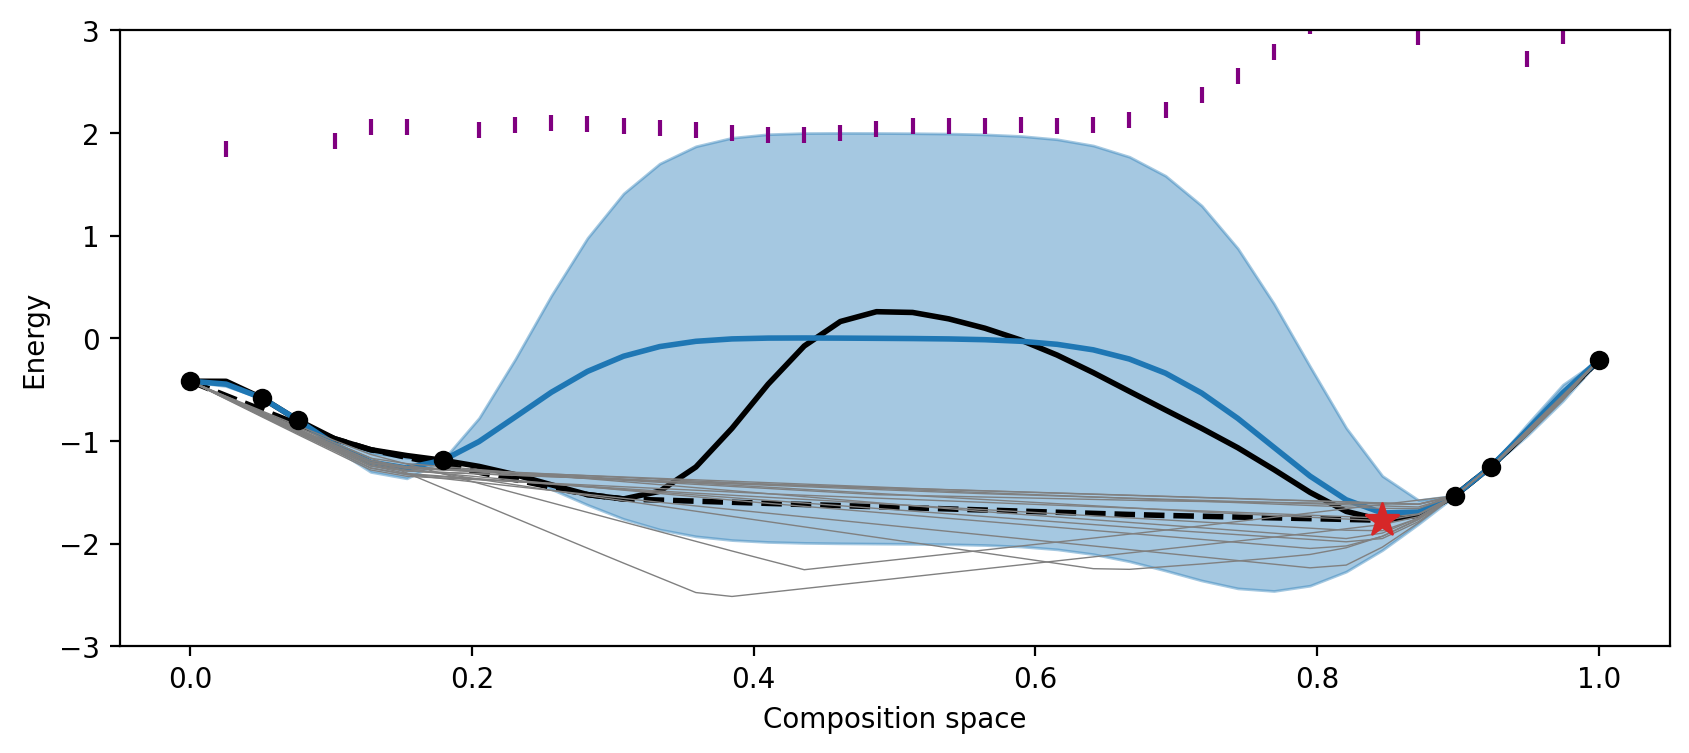

Iteration:  6
CPU times: user 40.8 s, sys: 16 ms, total: 40.8 s
Wall time: 39.5 s
[0.97435897] [2.16826092 2.29155213 2.42409995 2.40730761 2.37879092 2.37008804
 2.35948938 2.34408499 2.32076243 2.29585185 2.2712814  2.24260372
 2.22083487 2.20583463 2.20944054 2.22161523 2.23198592 2.26545129
 2.24751345 2.26631193 2.28388464 2.29846065 2.34181267 2.40686019
 2.47463663 2.55760789 2.64366689 2.71250526 2.61800793 1.98579273
 2.50553547 2.87701631]


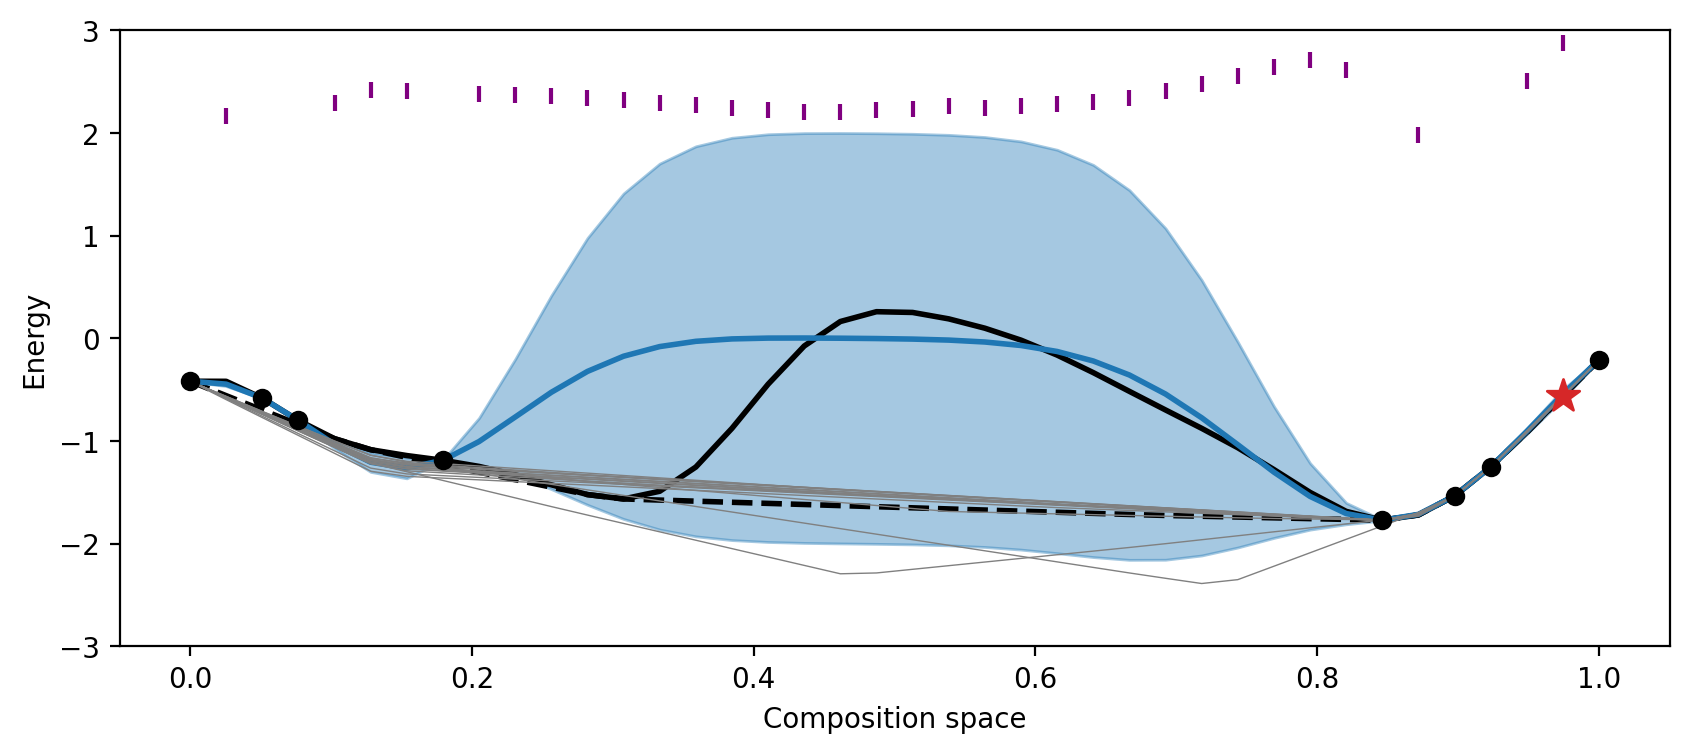

Iteration:  7
CPU times: user 39.2 s, sys: 8.26 ms, total: 39.2 s
Wall time: 37.9 s
[0.79487179] [2.58585838 2.64610156 2.72023458 2.69869882 2.61229685 2.63567243
 2.63763921 2.63908201 2.65308928 2.66395838 2.6750267  2.65715087
 2.64330842 2.61003938 2.62688382 2.67777734 2.68420587 2.70181213
 2.65936502 2.63622081 2.61433504 2.5907882  2.58825106 2.61584518
 2.658186   2.71681277 2.788326   2.84870027 2.78385131 1.76111021
 1.30908049]


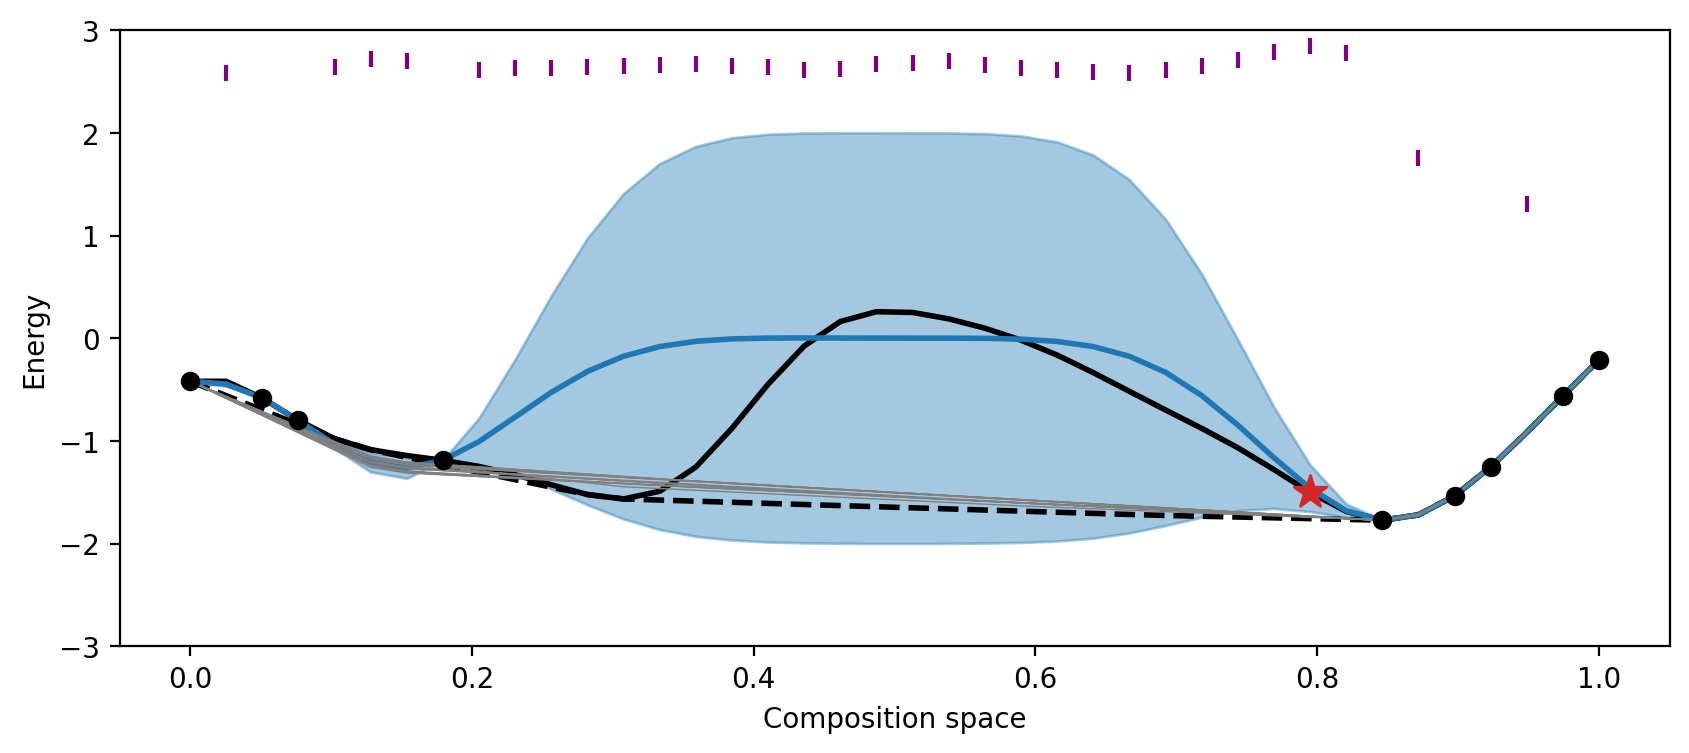

Iteration:  8
CPU times: user 38.3 s, sys: 16.2 ms, total: 38.3 s
Wall time: 37.1 s
[0.12820513] [2.57231573 2.7143581  2.86276103 2.84596014 2.72705649 2.77756234
 2.77664158 2.76174915 2.74357783 2.72706791 2.70290365 2.67309132
 2.65135267 2.64880421 2.67549147 2.71135393 2.69728633 2.70386407
 2.7180829  2.67237309 2.67084316 2.64687127 2.63235126 2.62312001
 2.61566081 2.62512528 2.66770914 1.44710398 0.9873838  0.98958885]


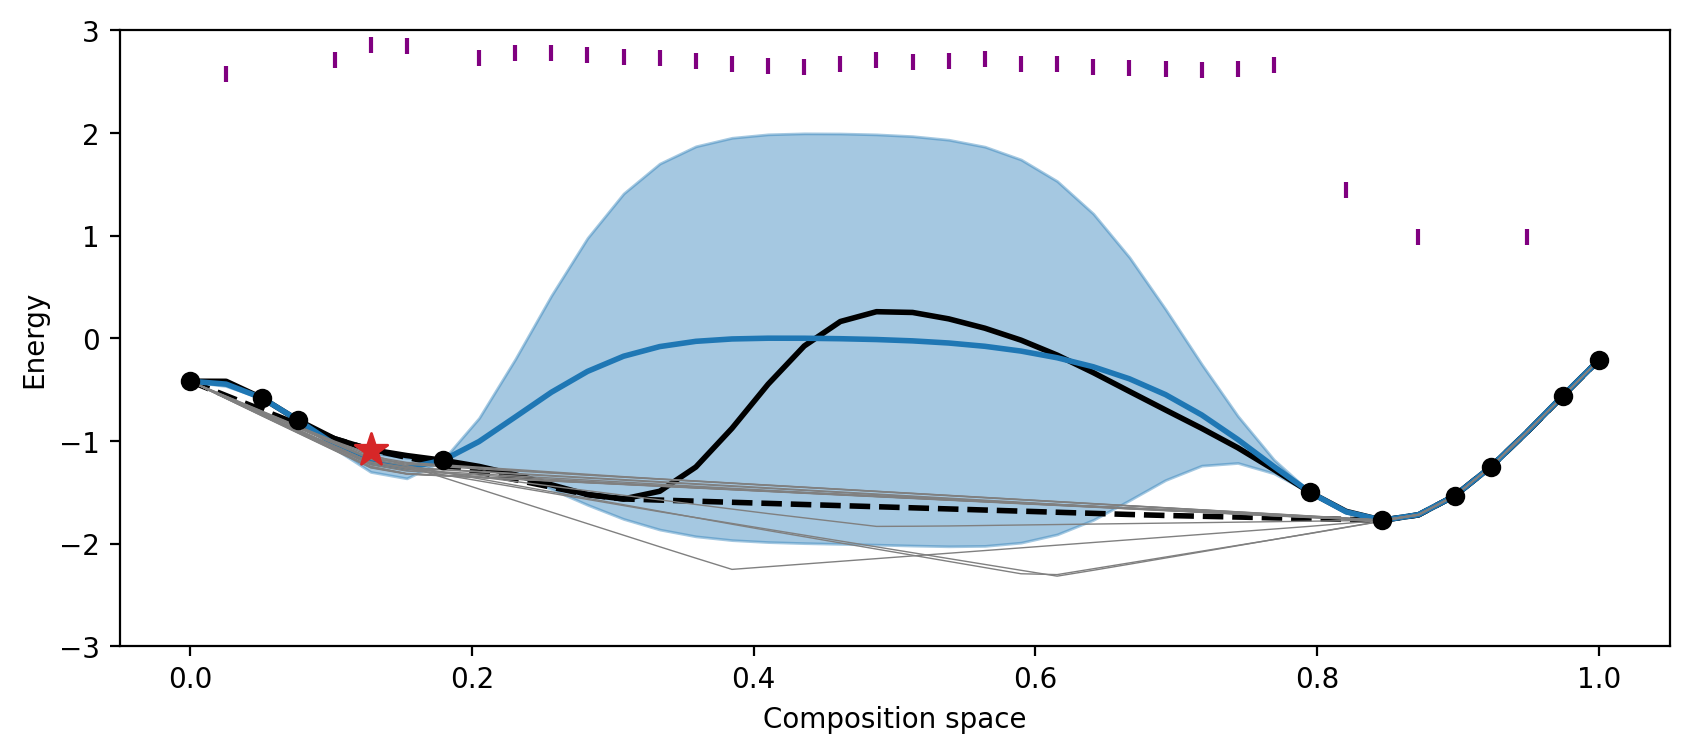

Iteration:  9
CPU times: user 53.4 s, sys: 35.7 ms, total: 53.5 s
Wall time: 52.2 s
[0.28205128] [ 1.47828815  0.74264985  1.1133484   2.31471955  2.84353584  3.04006273
  3.12094608  3.08073041  2.96035663  2.7722314   2.54363923  2.36280192
  2.24613418  2.18243086  2.1510733   2.13720437  2.15171478  2.14619856
  2.14315209  2.1249258   2.10765533  2.09020523  2.06798591  2.04856497
  2.0367422   1.91894608  0.4883133  -0.03297353  0.26578327]


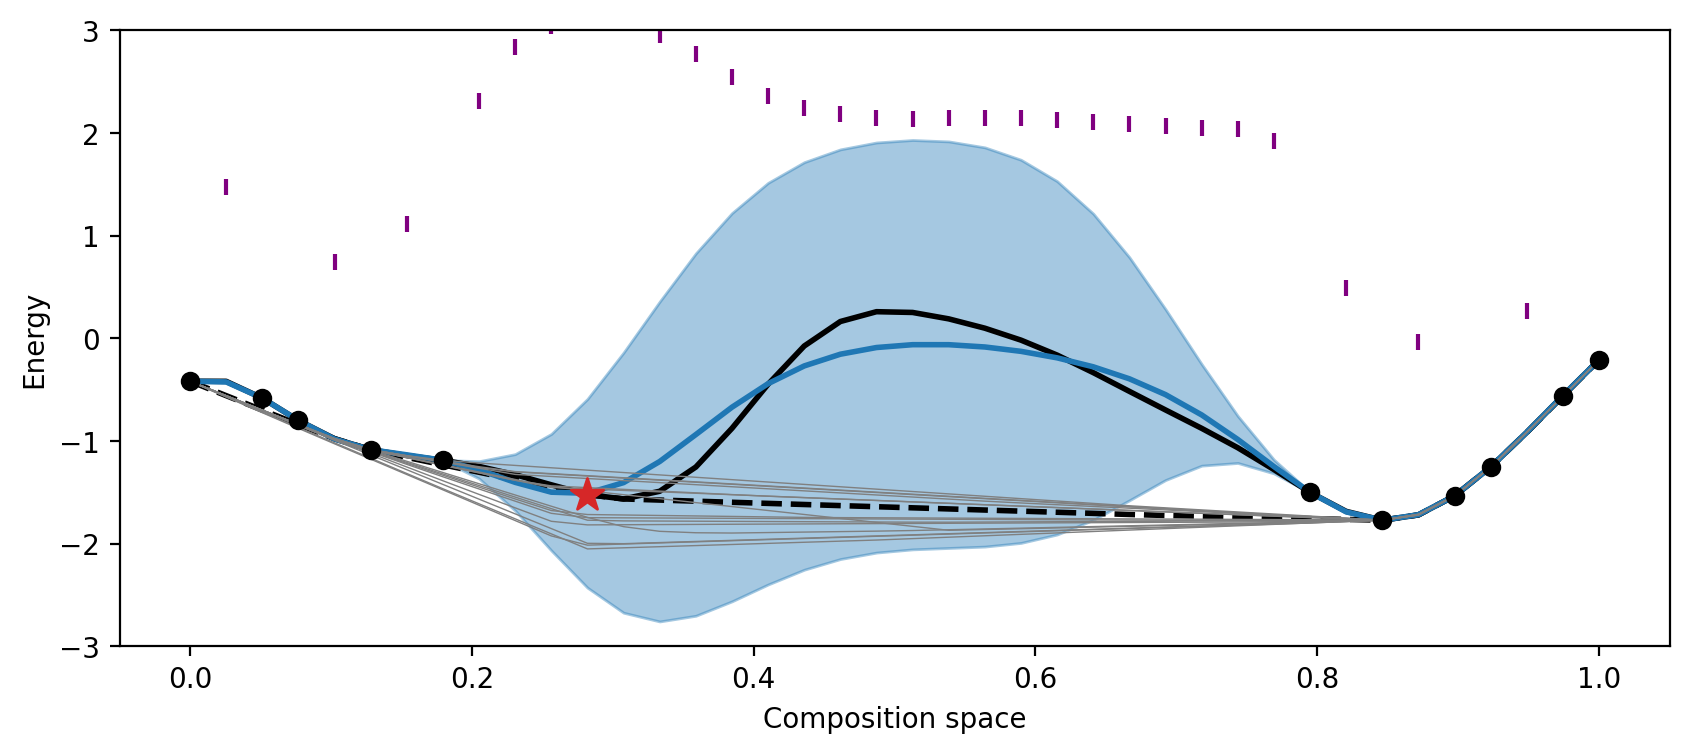

Iteration:  10
CPU times: user 41.4 s, sys: 3.71 ms, total: 41.4 s
Wall time: 40.1 s
[0.25641026] [2.2017288  1.44811267 1.72261129 2.94166572 3.52779692 3.62246951
 3.32229336 3.25045845 3.16123665 3.08899618 3.02784591 2.97203087
 2.91838249 2.88281127 2.86369809 2.83155809 2.80520428 2.78748308
 2.77606976 2.75732835 2.73775728 2.72246581 2.70444256 2.68913254
 2.62399968 1.39681993 0.73417671 1.2199578 ]


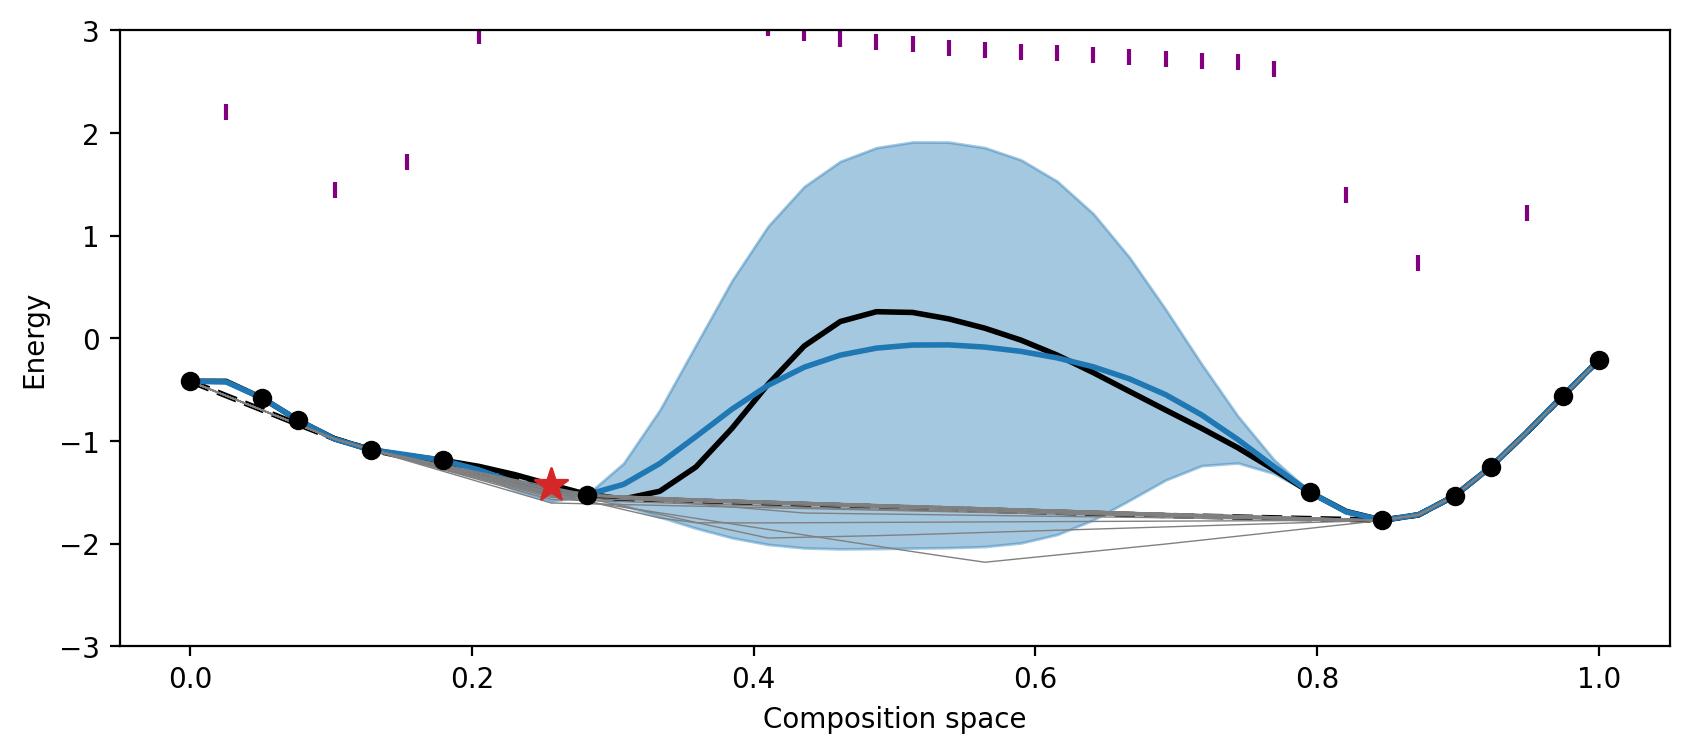

Iteration:  11
CPU times: user 44.7 s, sys: 23.8 ms, total: 44.7 s
Wall time: 43.4 s
[0.35897436] [ 1.00414267  0.03581362 -0.0806967   0.3966339   0.4808993   1.79338304
  2.59052348  2.75191822  2.74211954  2.63736436  2.47688331  2.318593
  2.20167586  2.11406436  2.05902827  2.03177599  2.02229869  2.02249243
  2.02236148  2.01782557  2.01218783  1.99944492  1.98584222  1.77995262
  0.24879677 -0.39857662  0.03452197]


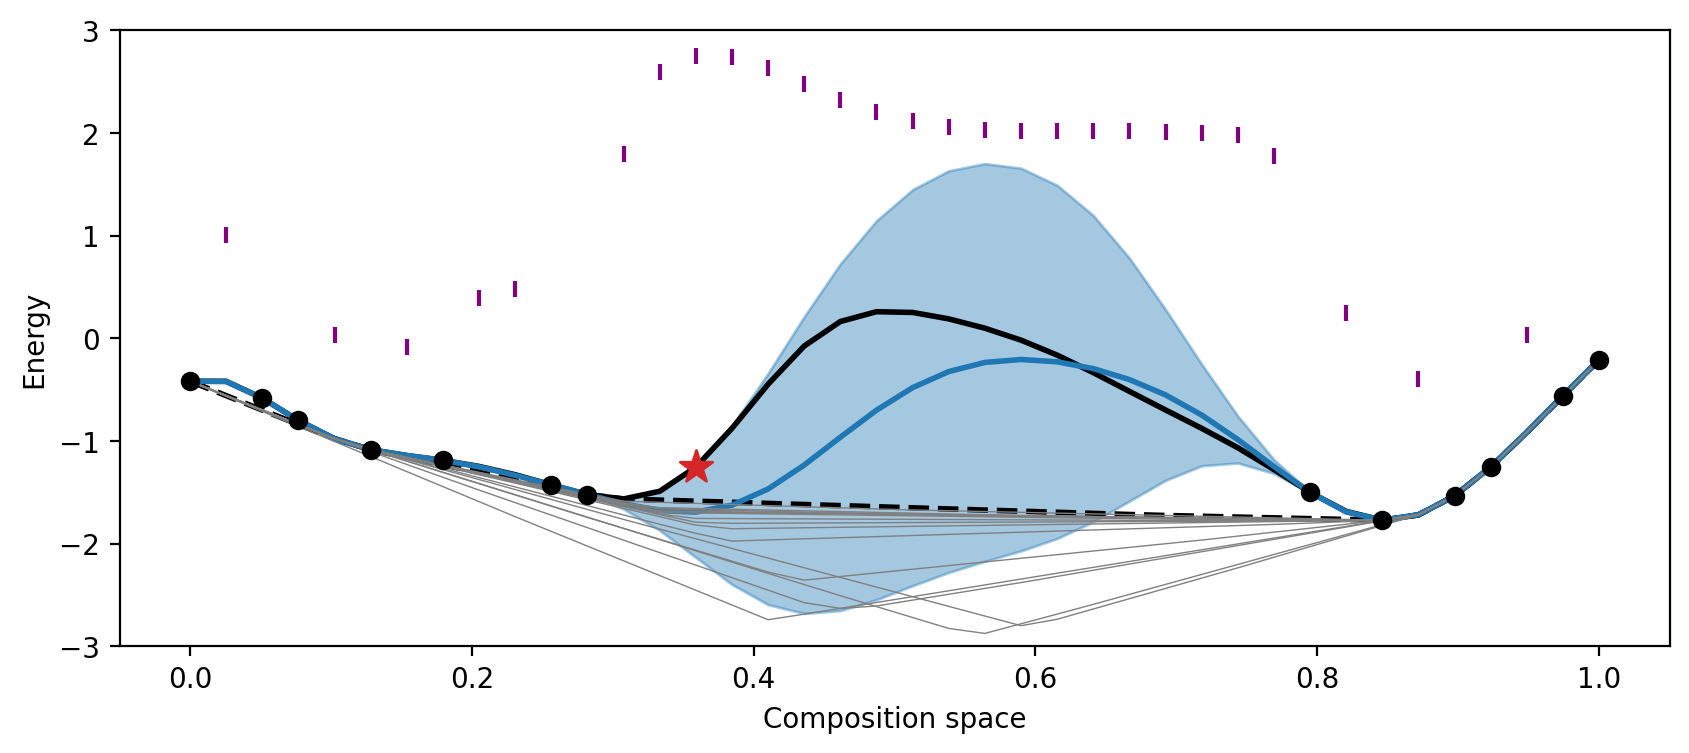

Iteration:  12
CPU times: user 56.3 s, sys: 15.7 ms, total: 56.3 s
Wall time: 55 s
[0.41025641] [ 0.87146964 -0.14867244 -0.17445928  0.03277913  0.02466771  1.07402902
  1.75553698  2.48610333  2.52823975  2.49533919  2.44780316  2.40158646
  2.37619     2.36858318  2.37834651  2.40176911  2.43271258  2.45688341
  2.47416888  2.4783187   2.46848083  2.42118973  2.12875895  0.40783817
 -0.45908342  0.09226507]


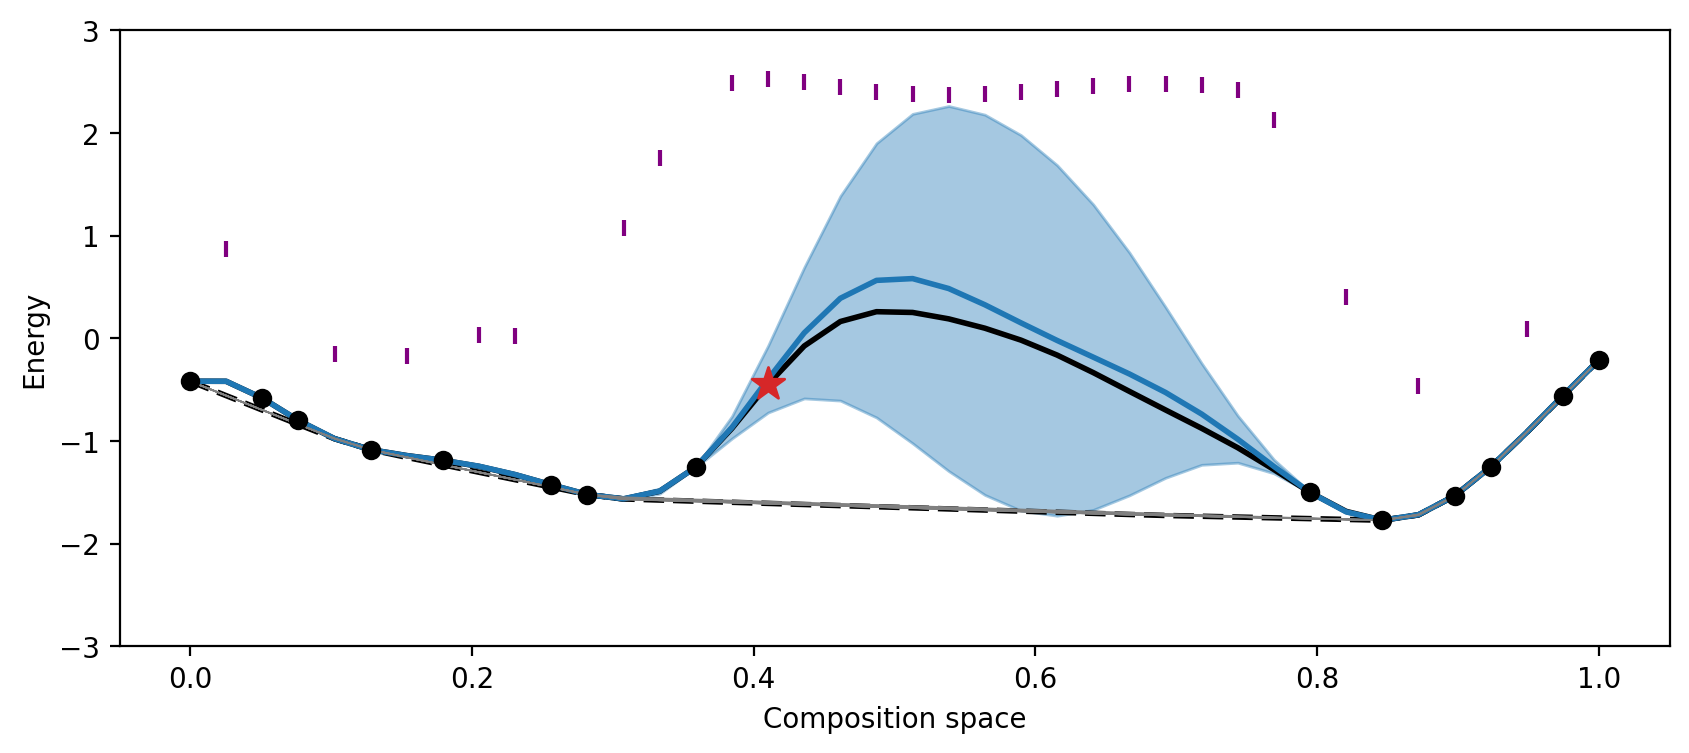

Iteration:  13
CPU times: user 50.5 s, sys: 11.6 ms, total: 50.5 s
Wall time: 49.2 s
[0.66666667] [ 1.16069864 -0.02490729 -0.11329966  0.01056834 -0.02737963  0.70204451
  1.07092219  1.25124019  2.30453737  2.33214551  2.37891399  2.42417107
  2.47014257  2.51342896  2.54880463  2.56725603  2.57860986  2.57999321
  2.57238676  2.54708552  2.49394264  2.22048577  0.56831299 -0.3257673
  0.23642075]


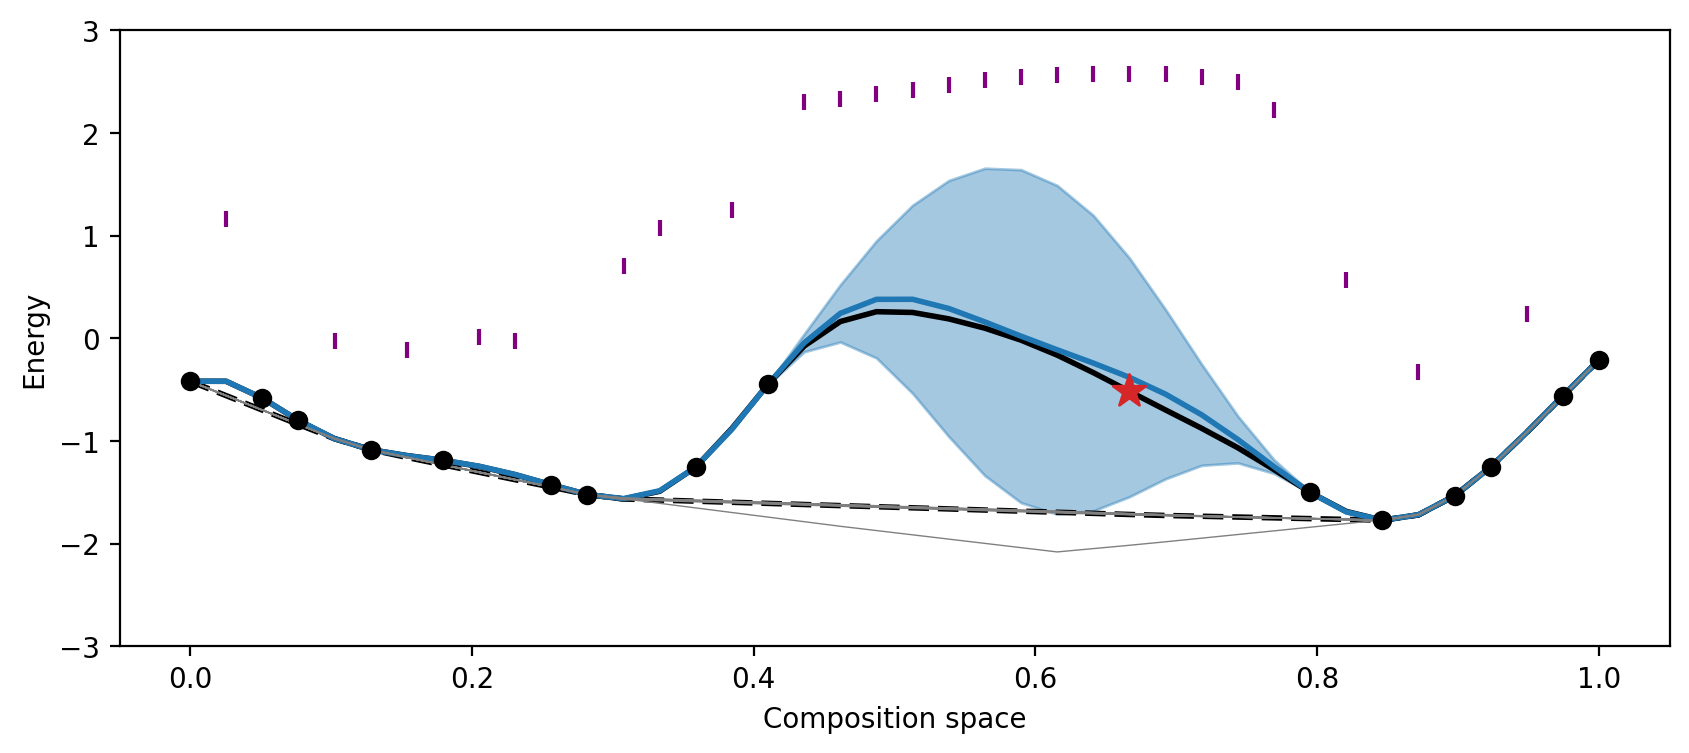

In [23]:
seed = 2
num_iters = 14
knot_N = 40
T = 200
J = 2000
npr.seed(seed); rng_key = jrnd.PRNGKey(seed)


# grid to discretize design space into
knot_x = jnp.linspace(0, 1, knot_N)
design_space = knot_x[:, jnp.newaxis]

true_y, true_envelope = generate_true_function(design_space, knot_N)

# Let's imagine that we start out by observing the two end points.
train_x = jnp.array([design_space[0], design_space[-1]]); train_y = jnp.array([true_y[0], true_y[-1]])
dataset = Dataset(X=train_x, y=train_y[:,jnp.newaxis])

#designs = design_space
designs = design_space[1:-1]

distances = []; distances.append(compute_distances(dataset, design_space, true_envelope))


# update model
pred_mean, pred_cov, posterior, params = update_model(dataset, design_space, rng_key, update_params=False)


for i in range(num_iters):
    print("Iteration: ", i)
    
    %time next_x, entropy_change = get_next_candidate_noqhull(posterior, params, dataset, designs, design_space, rng_key, T=T, J=J)
    print(next_x, entropy_change)
    
    Ys, envelopes, _ = sample_from_posterior(pred_mean, pred_cov, design_space, 100, get_env=True)
    plot_candidate(knot_x, true_y, true_envelope, pred_mean, pred_cov, envelopes[:25, :], dataset, next_x, entropy_change, 
                   plot_eig=True, plot_hulls=True, designs=designs, legend=False)
    
    #tight_samps = (Ys.T - envelopes) < 1e-3
    #plt.figure(figsize=(10,4))
    #plt.plot(design_space, tight_samps.mean(0))
    #plt.ylabel("Posterior mean of P(S | data)")
    
    # add observations to data and update list of designs
    dataset = dataset + Dataset(X=jnp.atleast_2d(next_x), y=jnp.atleast_2d(get_next_y(true_y, design_space, next_x)))
    
    designs = jnp.delete(designs, (designs == next_x).argmax())[:, jnp.newaxis]
    
    # update model
    pred_mean, pred_cov, posterior, params = update_model(dataset, design_space, rng_key, update_params=False)
    
    distances.append(compute_distances(dataset, design_space, true_envelope))

# Comparison between the two methods

Here we plot the distance of each data point from the true hull by iteration. 
Regions where the plot is flat from iteration to iteration represent stable points; 
small increases represent points that are close to the hull, 
and large increases represent points that are far from the hull.

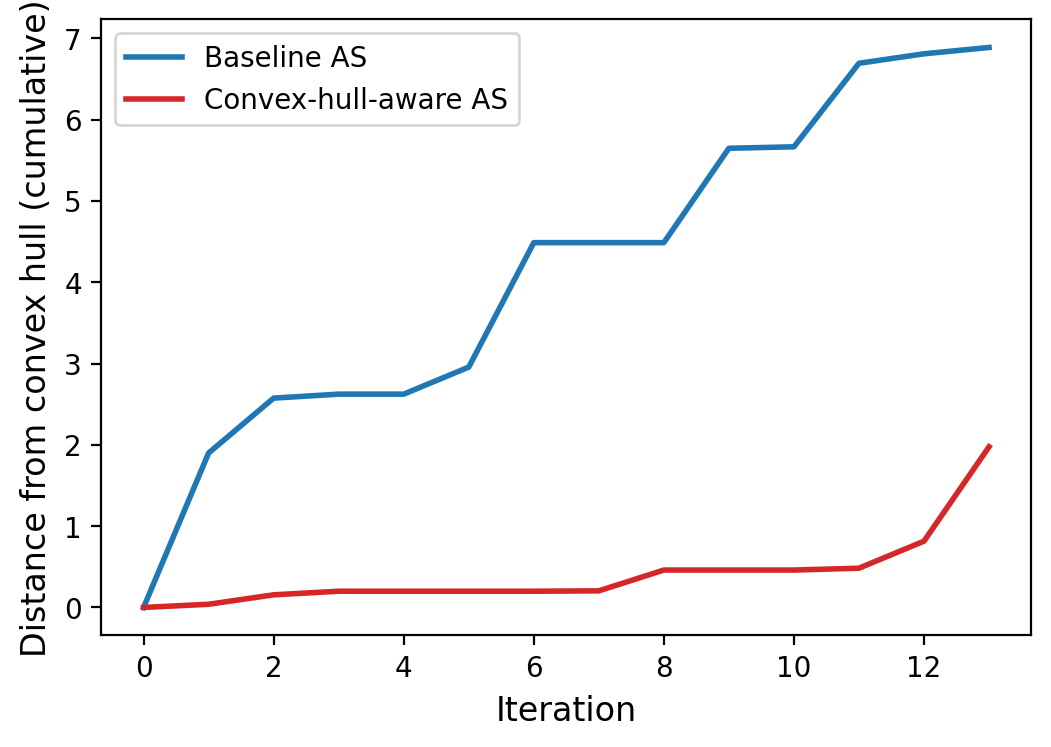

In [24]:
plt.figure(figsize=(6,4)); fs=12; niter=14
c_dist_baseline = [distance.sum() for distance in distances_baseline[0:niter]]
c_dist = [distance.sum() for distance in distances[0:niter]]
                     
plt.plot(c_dist_baseline, label="Baseline AS", lw=2, c="tab:blue")
plt.plot(c_dist, label="Convex-hull-aware AS", lw=2, c="tab:red")

plt.xlabel("Iteration", fontsize=fs); plt.ylabel("Distance from convex hull (cumulative)", fontsize=fs)
plt.legend()
#plt.xlim(-0.9, 12)

In [25]:
n_stable = 2; tol = 1e-2
stables_baseline = [n_stable]
for i in range(len(c_dist_baseline)-1):
    if (c_dist_baseline[i+1] - c_dist_baseline[i]) <= tol:
        n_stable += 1
    stables_baseline.append(n_stable)
    
n_stable = 2
stables = [n_stable]
for i in range(len(c_dist)-1):
    if (c_dist[i+1] - c_dist[i]) <= tol:
        n_stable += 1
    stables.append(n_stable)

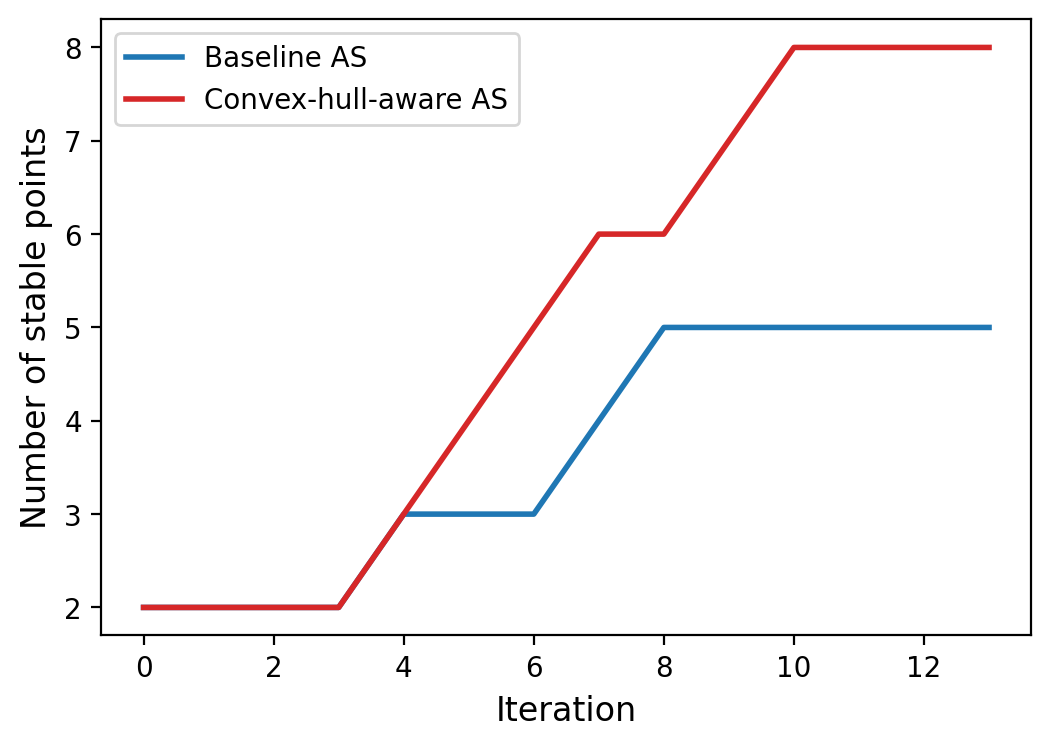

In [26]:
plt.figure(figsize=(6,4)); fs=12
                     
plt.plot(stables_baseline, label="Baseline AS", lw=2, c="tab:blue")
plt.plot(stables, label="Convex-hull-aware AS", lw=2, c="tab:red")

plt.xlabel("Iteration", fontsize=fs); plt.ylabel("Number of stable points", fontsize=fs)
plt.legend()